<h1><center><font size="6">Bundesliga Game Predictor</font></center></h1>

<img src="https://upload.wikimedia.org/wikibooks/en/a/a1/GER_Bundesliga_Logo.jpg"></img>

# <a id='0'>Table of Contents</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
 - <a href='#21'>Load packages</a>  
 - <a href='#22'>Load the data</a> 
- <a href='#3'>Data exploration</a>   
 - <a href='#31'>Check for missing data</a>
 - <a href='#32'>Cleaning the Data</a>
- <a href='#4'>EDA</a>
- <a href='#5'>Build a Baseline Model</a>
 - <a href='#51'>Logistic Regression</a>  
 - <a href='#52'>RandomForestClassifier</a>     
 - <a href='#53'>Gradient Boosting (using XGBoost)</a>
 - <a href='#54'>K-nearest neighbours</a>
- <a href='#6'>Model Refinement</a>  
 - <a href='#61'>Preprocessing</a>  
 - <a href='#62'>Feature Engineering Part 1</a>     
 - <a href='#63'>Feature Engineering Part 2</a>
 - <a href='#64'>Modelling with new Features</a>
- <a href='#7'>Predicting the 23/24 Bundesliga games</a>
- <a href='#8'>Conclusions</a>

# <a id='1'>Introduction</a>  

Football is a sport that is very present in people life’s, people use to watch, play, and also bet. Thinking about betting, we clearly can see that football is a very unpredictable sport, and it does not acquire serious research to prove that. So, the main objective of this project is to create a supervised machine learning algorithm that predicts the football matches results.

# <a id='2'>Prepare the data analysis</a> 

Before starting the analysis, we need to make few preparation: load the packages, load and inspect the data.

## <a id='21'>Load packages</a>

We load the packages used for the analysis.

In [1]:
# Basic libraries
import pymysql
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Other
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

<a href="#0"><font size="1">Go to top</font></a> 

## <a id='22'>Load the data</a>  

Let's see first what data files do we have in the root directory.

In [2]:
# reading the data
data = pd.read_csv("data/bulidata.csv")
data.head()

,Unnamed: 0,MATCH_DATE,LEAGUE_NAME,SEASON,LEAGUE,FINISHED,LOCATION,VIEWER,MATCHDAY,MATCHDAY_NR,HOME_TEAM_ID,HOME_TEAM_NAME,HOME_TEAM,HOME_ICON,AWAY_TEAM_ID,AWAY_TEAM_NAME,AWAY_TEAM,AWAY_ICON,GOALS_HOME,GOALS_AWAY,DRAW,WIN_HOME,WIN_AWAY
0,0,2005-08-05 20:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,München,NaN,1. Spieltag,1,40,FC Bayern München,Bayern,https://i.imgur.com/jJEsJrj.png,87,Borussia Mönchengladbach,Gladbach,https://i.imgur.com/KSIk0Eu.png,3,0,0.0,1.0,0.0
1,1,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Köln,NaN,1. Spieltag,1,65,1. FC Köln,Köln,https://upload.wikimedia.org/wikipedia/en/thum...,81,1. FSV Mainz 05,Mainz,https://upload.wikimedia.org/wikipedia/commons...,1,0,0.0,1.0,0.0
2,2,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Duisburg,NaN,1. Spieltag,1,107,MSV Duisburg,Duisburg,https://upload.wikimedia.org/wikipedia/en/c/c8...,16,VfB Stuttgart,Stuttgart,https://i.imgur.com/v0tkpNx.png,1,1,1.0,0.0,0.0
3,3,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Hamburg,NaN,1. Spieltag,1,100,Hamburger SV,HSV,https://upload.wikimedia.org/wikipedia/commons...,79,1. FC Nürnberg,Nürnberg,https://upload.wikimedia.org/wikipedia/commons...,3,0,0.0,1.0,0.0
4,4,2005-08-06 15:30:00,1. Fussball-Bundesliga 2005/2006,2005,bl1,True,Wolfsburg,NaN,1. Spieltag,1,131,VfL Wolfsburg,Wolfsburg,https://i.imgur.com/ucqKV4B.png,7,Borussia Dortmund,BVB,https://upload.wikimedia.org/wikipedia/commons...,2,2,1.0,0.0,0.0


<a href="#0"><font size="1">Go to top</font></a>  

# <a id='3'>Data exploration</a>  

Each row corresponds to a game and contains the following information:

- **Unnamed**: 0: An index or identifier for each row. This column is usually created when saving a DataFrame to a .csv file in pandas when the option index=False is not specified. We might not need this for our analysis.
- **MATCH_DATE**: The date and time when the match was played. Ranges from some time in 2005 to 2023.
- **LEAGUE_NAME**: The name of the league in which the match was played. There are 18 unique league names, with "1. Fussball-Bundesliga 2005/2006" appearing most frequently (306 times).
- **SEASON**: The year of the season in which the match was played. Ranges from 2005 to 2022.
- **LEAGUE**: A short identifier for the league.
- **FINISHED**: A boolean indicating whether the match has finished or not.
- **LOCATION**: The city where the match was played. There are 33 unique locations, with "Berlin" appearing most frequently (340 times).
- **VIEWER**: This might represent the number of viewers of the match, but it looks like it's null in our sample. While the viewer data is largely missing, it ranges from 0 to 81365 for the rows that do have this information.
- **MATCHDAY**: The matchday on which the game was played.
- **MATCHDAY_NR**: The matchday number. Ranges from 1 to 34.
- **HOME_TEAM_ID**: The identifier for the home team.
- **HOME_TEAM_NAME**: The name of the home team.
- **HOME_TEAM**: A short form of the home team name.
- **HOME_ICON**: A link to the icon of the home team.
- **AWAY_TEAM_ID**: The identifier for the away team.
- **AWAY_TEAM_NAME**: The name of the away team.
- **AWAY_TEAM**: A short form of the away team name.
- **AWAY_ICON**: A link to the icon of the away team.
- **GOALS_HOME**: The number of goals scored by the home team.
- **GOALS_AWAY**: The number of goals scored by the away team.
- **DRAW**: A binary indicator of whether the match was a draw.
- **WIN_HOME**: A binary indicator of whether the home team won.
- **WIN_AWAY**: A binary indicator of whether the away team won.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5508 entries, 0 to 5507
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      5508 non-null   int64  
 1   MATCH_DATE      5508 non-null   object 
 2   LEAGUE_NAME     5508 non-null   object 
 3   SEASON          5508 non-null   int64  
 4   LEAGUE          5508 non-null   object 
 5   FINISHED        5508 non-null   bool   
 6   LOCATION        5508 non-null   object 
 7   VIEWER          1682 non-null   float64
 8   MATCHDAY        5508 non-null   object 
 9   MATCHDAY_NR     5508 non-null   int64  
 10  HOME_TEAM_ID    5508 non-null   int64  
 11  HOME_TEAM_NAME  5508 non-null   object 
 12  HOME_TEAM       5508 non-null   object 
 13  HOME_ICON       5508 non-null   object 
 14  AWAY_TEAM_ID    5508 non-null   int64  
 15  AWAY_TEAM_NAME  5508 non-null   object 
 16  AWAY_TEAM       5474 non-null   object 
 17  AWAY_ICON       5508 non-null   o

In [4]:
data.shape

(5508, 23)

In [5]:
data.describe().round(1)

,Unnamed: 0,SEASON,VIEWER,MATCHDAY_NR,HOME_TEAM_ID,AWAY_TEAM_ID,GOALS_HOME,GOALS_AWAY,DRAW,WIN_HOME,WIN_AWAY
count,5508.0,5508.0,1682.0,5508.0,5508.0,5508.0,5508.0,5508.0,5508.0,5508.0,5508.0
mean,2755.1,2013.5,41841.0,17.5,109.8,109.8,1.4,1.1,0.3,0.4,0.3
std,1590.8,5.2,18057.4,9.8,231.5,231.5,1.3,1.1,0.5,0.5,0.5
min,0.0,2005.0,0.0,1.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0
25%,1378.8,2009.0,28176.2,9.0,40.0,40.0,0.0,0.0,0.0,0.0,0.0
50%,2755.5,2013.5,41000.0,17.5,81.0,81.0,1.0,1.0,0.0,0.0,0.0
75%,4132.2,2018.0,52121.0,26.0,112.0,112.0,2.0,2.0,1.0,1.0,1.0
max,5509.0,2022.0,81365.0,34.0,1635.0,1635.0,9.0,8.0,1.0,1.0,1.0


Before proceeding, let's verify the completeness and types of the data. It's important to understand if there are any missing values and the data types of each column. We also need to check the number of unique values in categorical columns. This will help us understand the data better and design an appropriate data analysis and modeling strategy.

### Define Target Variable

In [6]:
# Summarize 'win_home', 'win_away', 'draw' to 'outcome'
data['outcome'] = data[['WIN_HOME', 'WIN_AWAY', 'DRAW']].idxmax(axis=1)

# Convert the 'outcome' column to lowercase
data['outcome'] = data['outcome'].str.lower()
print(data['outcome'].value_counts())

win_home    2345
draw        1601
win_away    1562
Name: outcome, dtype: int64


## <a id='31'>Check for missing data</a>  

In [7]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(data)

,Total,Percent
VIEWER,3826,69.462600
AWAY_TEAM,34,0.617284
Unnamed: 0,0,0.000000
HOME_ICON,0,0.000000
WIN_AWAY,0,0.000000
WIN_HOME,0,0.000000
DRAW,0,0.000000
GOALS_AWAY,0,0.000000
GOALS_HOME,0,0.000000
AWAY_ICON,0,0.000000


**Here's a summary of the information about the data:**

- The dataset consists of 5508 rows and 23 columns.
- The data types are varied: boolean, float, integer, and object (which can include strings).
- The Unnamed: 0 column appears to be an index column which we won't need for our analysis.
- The VIEWER column has a significant amount of missing values (3826 out of 5508).
- The AWAY_TEAM column has some missing values as well (34 out of 5508).

## <a id='32'>Cleaning the Data</a>  

### Change Format of Date

In [8]:
# Convert MATCH_DATE to datetime format
data['MATCH_DATE'] = pd.to_datetime(data['MATCH_DATE'])
data.dtypes

Unnamed: 0                 int64
MATCH_DATE        datetime64[ns]
LEAGUE_NAME               object
SEASON                     int64
LEAGUE                    object
FINISHED                    bool
LOCATION                  object
VIEWER                   float64
MATCHDAY                  object
MATCHDAY_NR                int64
HOME_TEAM_ID               int64
HOME_TEAM_NAME            object
HOME_TEAM                 object
HOME_ICON                 object
AWAY_TEAM_ID               int64
AWAY_TEAM_NAME            object
AWAY_TEAM                 object
AWAY_ICON                 object
GOALS_HOME                 int64
GOALS_AWAY                 int64
DRAW                     float64
WIN_HOME                 float64
WIN_AWAY                 float64
outcome                   object
dtype: object

### Drop unnecessary columns

In [9]:
# Dropping unnecessary columns
data.drop(['Unnamed: 0', 'LEAGUE_NAME', 'HOME_ICON', 'AWAY_ICON', 'MATCH_DATE', 'LEAGUE', 'FINISHED', 'MATCHDAY', 'HOME_TEAM', 'AWAY_TEAM', 'VIEWER'], axis=1, inplace=True)
data.head()

,SEASON,LOCATION,MATCHDAY_NR,HOME_TEAM_ID,HOME_TEAM_NAME,AWAY_TEAM_ID,AWAY_TEAM_NAME,GOALS_HOME,GOALS_AWAY,DRAW,WIN_HOME,WIN_AWAY,outcome
0,2005,München,1,40,FC Bayern München,87,Borussia Mönchengladbach,3,0,0.0,1.0,0.0,win_home
1,2005,Köln,1,65,1. FC Köln,81,1. FSV Mainz 05,1,0,0.0,1.0,0.0,win_home
2,2005,Duisburg,1,107,MSV Duisburg,16,VfB Stuttgart,1,1,1.0,0.0,0.0,draw
3,2005,Hamburg,1,100,Hamburger SV,79,1. FC Nürnberg,3,0,0.0,1.0,0.0,win_home
4,2005,Wolfsburg,1,131,VfL Wolfsburg,7,Borussia Dortmund,2,2,1.0,0.0,0.0,draw


I have removed the columns as they are not needed for our analysis.

## Standarize column names

In [10]:
def data_clean():
    data.columns = cc = [column.lower().replace(' ', '_') for column in data]

In [11]:
data_clean()
data.columns

Index(['season', 'location', 'matchday_nr', 'home_team_id', 'home_team_name',
       'away_team_id', 'away_team_name', 'goals_home', 'goals_away', 'draw',
       'win_home', 'win_away', 'outcome'],
      dtype='object')

In [12]:
data.to_csv('data.csv', index=False)

# <a id='4'>EDA</a>

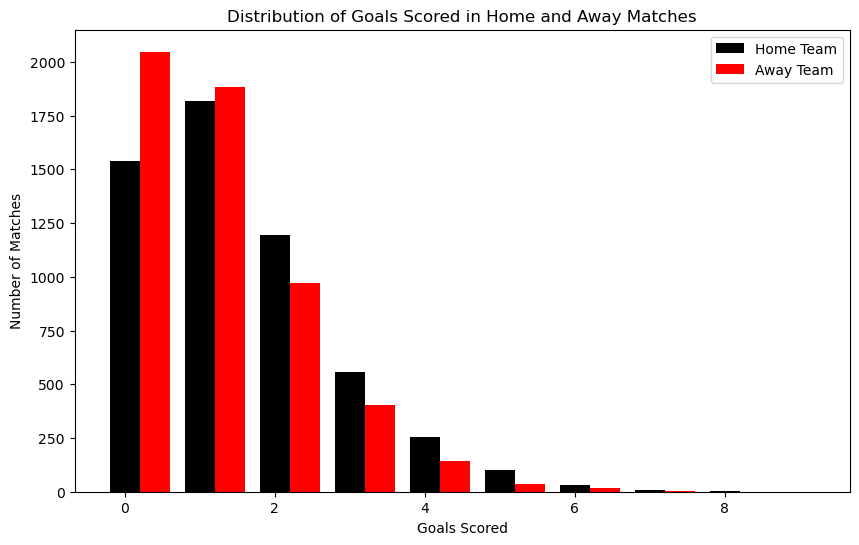

In [13]:
goal_distribution_home = data['goals_home'].value_counts().sort_index()
goal_distribution_away = data['goals_away'].value_counts().sort_index()

# Define the width of each bar
bar_width = 0.4

# Create an array of indices for the bars for the away team's goals with a little offset
indices_away = goal_distribution_away.index + bar_width

plt.figure(figsize=(10, 6))
plt.bar(goal_distribution_home.index, goal_distribution_home.values, width=bar_width, color='black', label='Home Team')
plt.bar(indices_away, goal_distribution_away.values, width=bar_width, color='red', label='Away Team')
plt.xlabel('Goals Scored')
plt.ylabel('Number of Matches')
plt.title('Distribution of Goals Scored in Home and Away Matches')
plt.legend()
plt.show()


In [14]:
# Calculate the average number of goals scored at home and away for each team
avg_goals_home_team = data.groupby('home_team_name')['goals_home'].mean()
avg_goals_away_team = data.groupby('away_team_name')['goals_away'].mean()

# Calculate the difference between home and away goals
home_advantage = avg_goals_home_team - avg_goals_away_team

# Get the top 5 teams with the most significant home advantage
top_home_advantage = home_advantage.sort_values(ascending=False).head(5)
top_home_advantage

home_team_name
FC Bayern München     0.643791
Alemannia Aachen      0.588235
Hannover 96           0.529412
FC Energie Cottbus    0.529412
FC Schalke 04         0.422145
dtype: float64

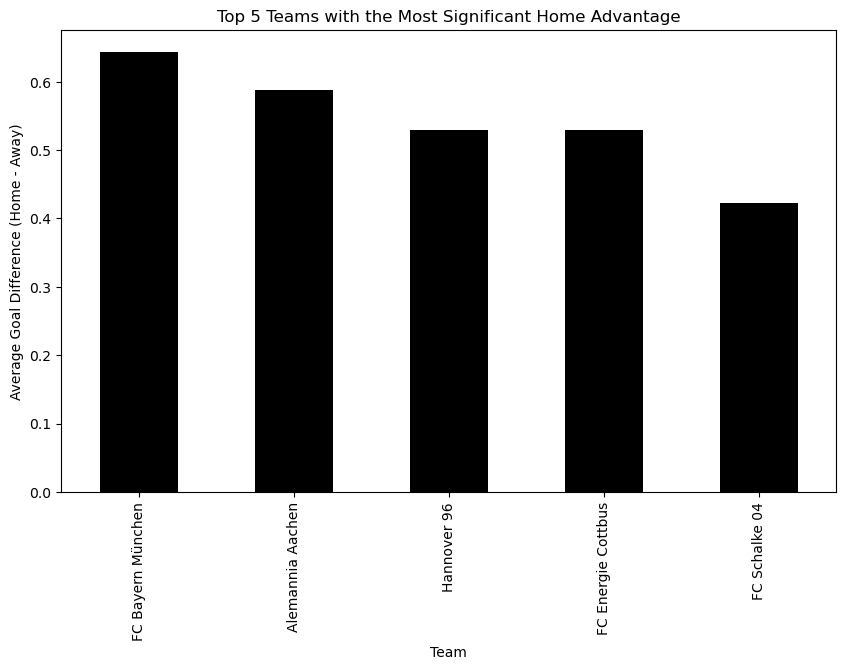

In [15]:
# Plot a bar chart
plt.figure(figsize=(10, 6))
top_home_advantage.plot(kind='bar', color='black')
plt.xlabel('Team')
plt.ylabel('Average Goal Difference (Home - Away)')
plt.title('Top 5 Teams with the Most Significant Home Advantage')
plt.show()

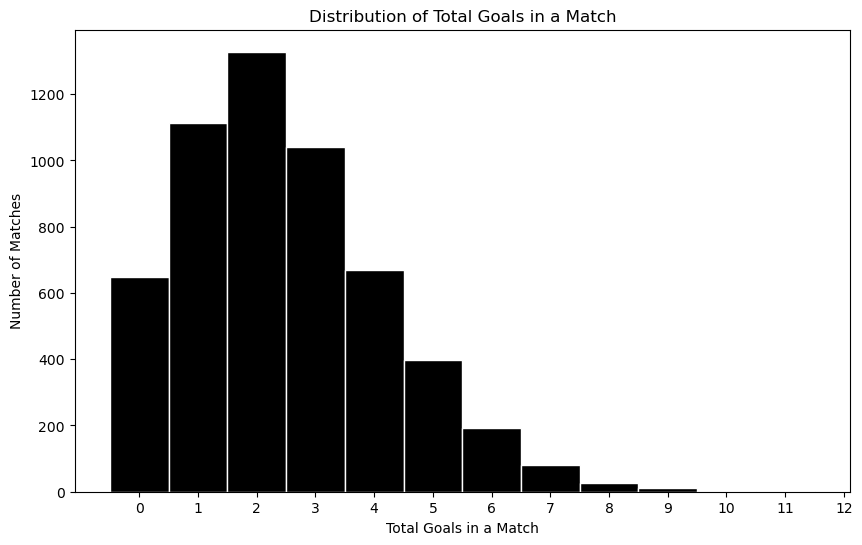

In [16]:
# Calculate the total number of goals in each match
data['total_goals'] = data['goals_home'] + data['goals_away']

# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(data['total_goals'], bins=range(0, data['total_goals'].max() + 2), align='left', color='black', edgecolor='white')
plt.xlabel('Total Goals in a Match')
plt.ylabel('Number of Matches')
plt.title('Distribution of Total Goals in a Match')
plt.xticks(range(0, data['total_goals'].max() + 2))
plt.show()

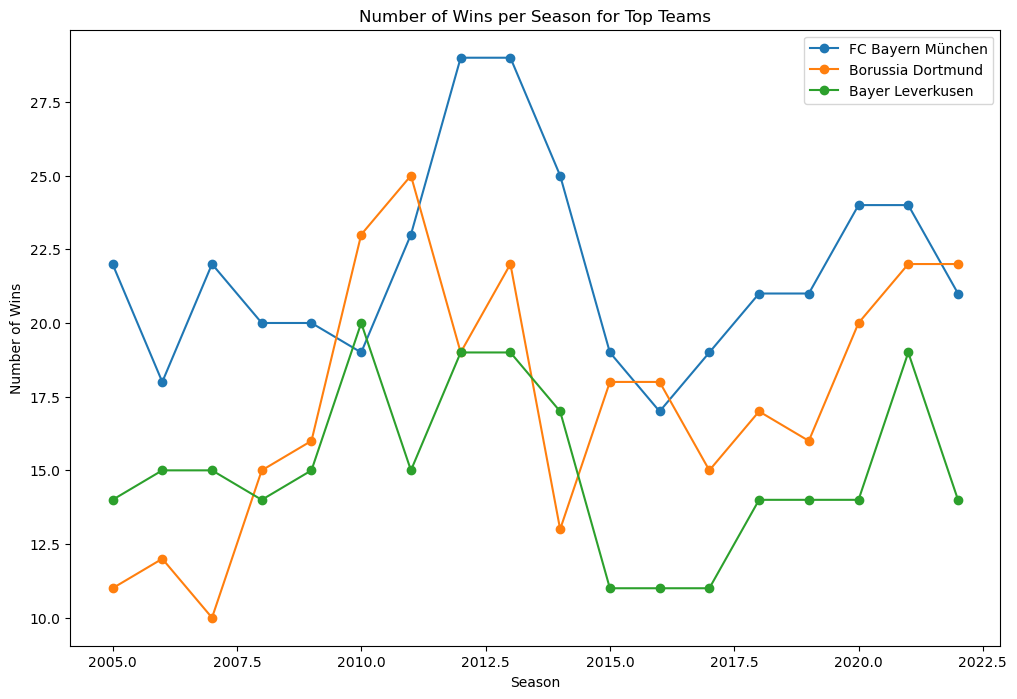

In [17]:
# Calculate the total number of wins for each team
total_wins_home = data[data['outcome'] == 'win_home']['home_team_name'].value_counts()
total_wins_away = data[data['outcome'] == 'win_away']['away_team_name'].value_counts()

# Combine home and away wins
total_wins = total_wins_home.add(total_wins_away, fill_value=0)

# Get the top 3 teams based on total number of wins
top_teams = total_wins.sort_values(ascending=False).head(3).index.tolist()

# Filter the data for these top teams
top_teams_data = data[(data['home_team_name'].isin(top_teams)) | (data['away_team_name'].isin(top_teams))]

# Initialize a data frame to store the number of wins per season for each top team
wins_per_season = pd.DataFrame()

# Calculate the number of wins per season for each top team
for team in top_teams:
    wins_home = top_teams_data[(top_teams_data['home_team_name'] == team) & (top_teams_data['outcome'] == 'win_home')].groupby('season').size()
    wins_away = top_teams_data[(top_teams_data['away_team_name'] == team) & (top_teams_data['outcome'] == 'win_away')].groupby('season').size()
    wins = wins_home.add(wins_away, fill_value=0)
    wins_per_season[team] = wins

# Plot the number of wins per season for each top team
wins_per_season.plot(kind='line', marker='o', figsize=(12, 8))
plt.xlabel('Season')
plt.ylabel('Number of Wins')
plt.title('Number of Wins per Season for Top Teams')
plt.show()

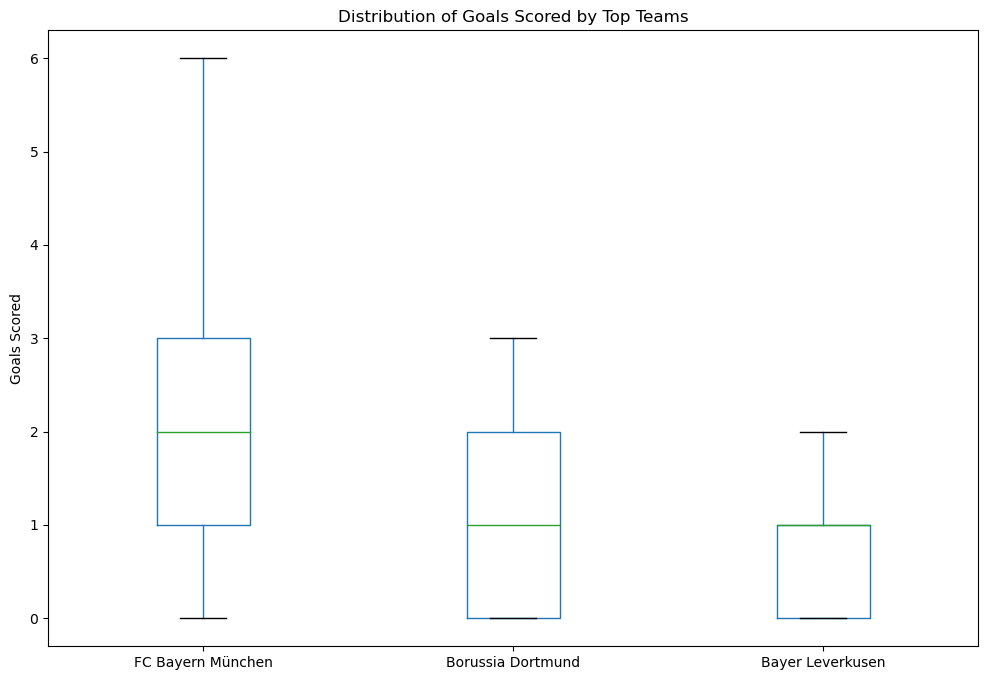

In [18]:
# Initialize a data frame to store the goals scored by the top teams in home and away matches
goals_top_teams = pd.DataFrame()

# Get the goals scored by the top teams in home and away matches
for team in top_teams:
    goals_home = data[data['home_team_name'] == team]['goals_home']
    goals_away = data[data['away_team_name'] == team]['goals_away']
    goals = pd.concat([goals_home, goals_away])
    goals_top_teams[team] = goals

# Create a box plot for the distribution of goals scored by the top teams
plt.figure(figsize=(12, 8))
goals_top_teams.boxplot(showfliers=False)
plt.ylabel('Goals Scored')
plt.title('Distribution of Goals Scored by Top Teams')
plt.grid()
plt.show()

In [19]:
# top 5 teams with the highest number of wins in each season
data_wins = data[data['outcome'].isin(['win_home', 'win_away'])].copy()
data_wins['winning_team'] = data_wins.apply(lambda row: row['home_team_name'] if row['outcome'] == 'win_home' else row['away_team_name'], axis=1)

top_teams = data_wins.groupby(['season', 'winning_team']).size().reset_index(name='num_wins')
top_teams = top_teams.sort_values(['season', 'num_wins'], ascending=[True, False])
top_5_teams = top_teams.groupby('season').head(5)

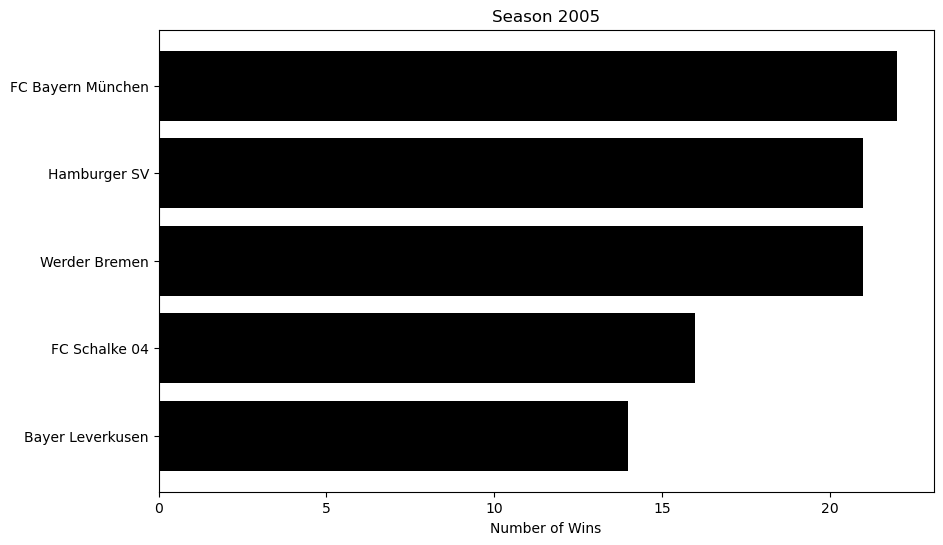

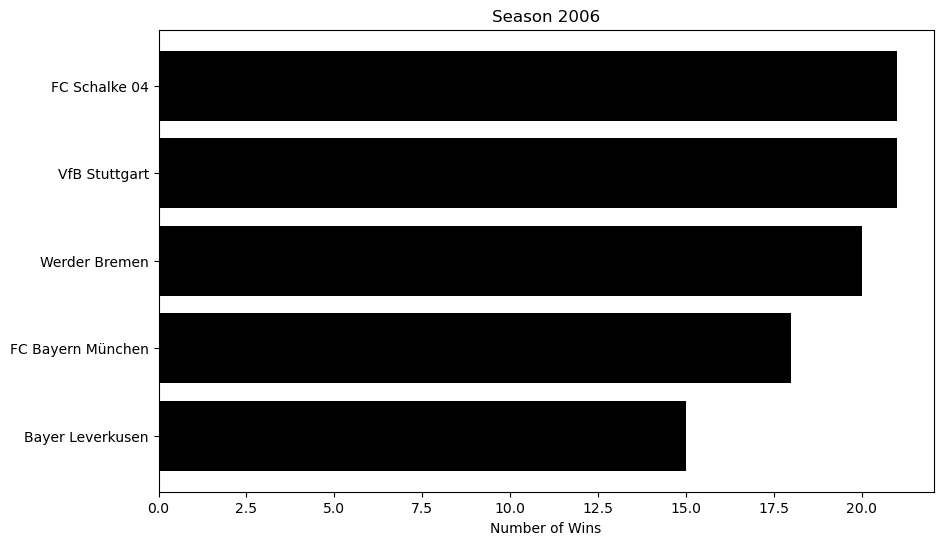

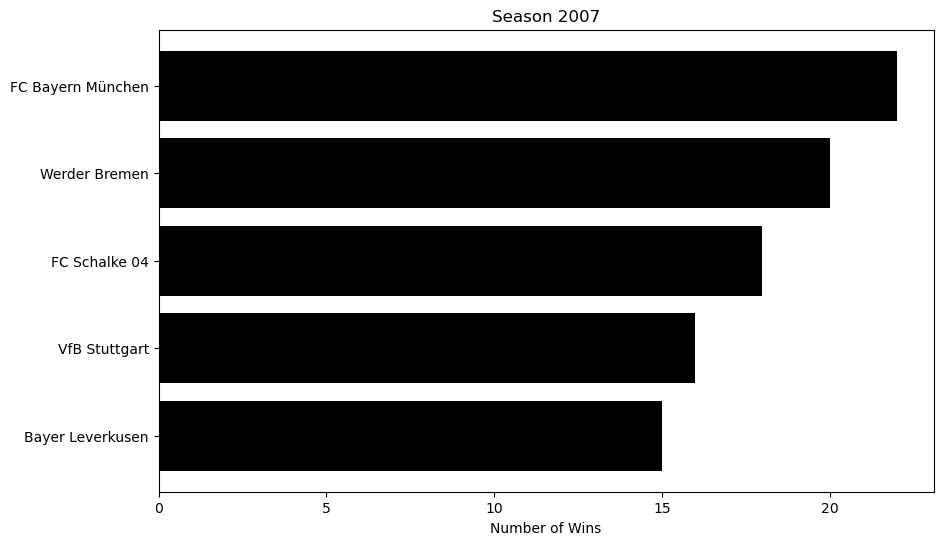

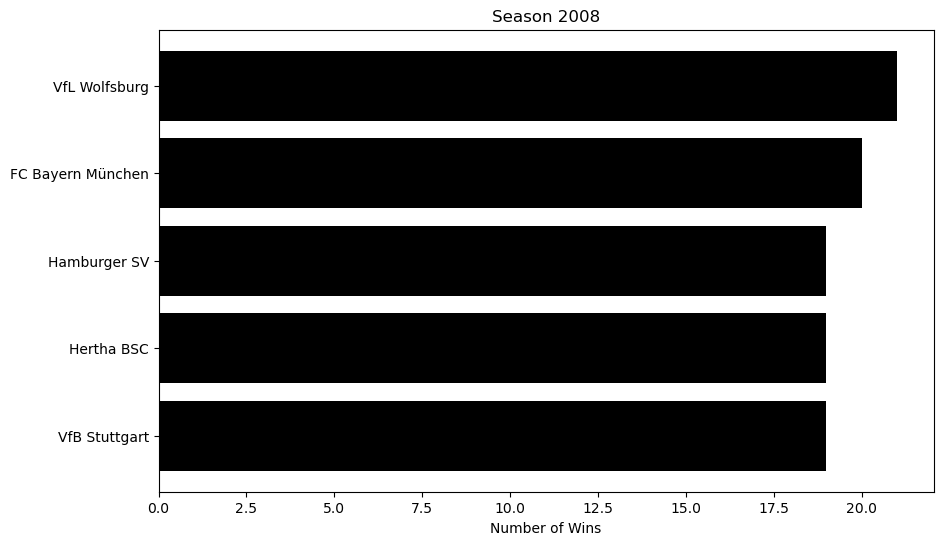

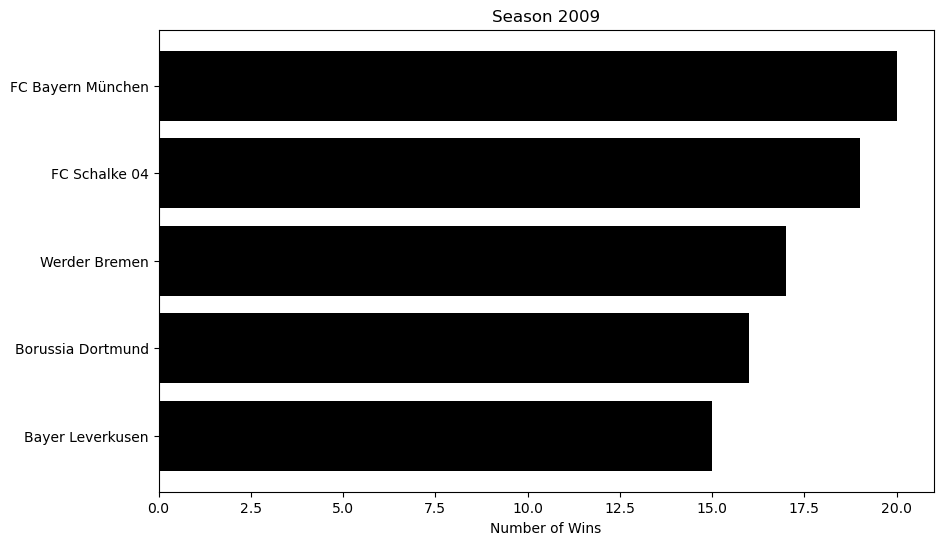

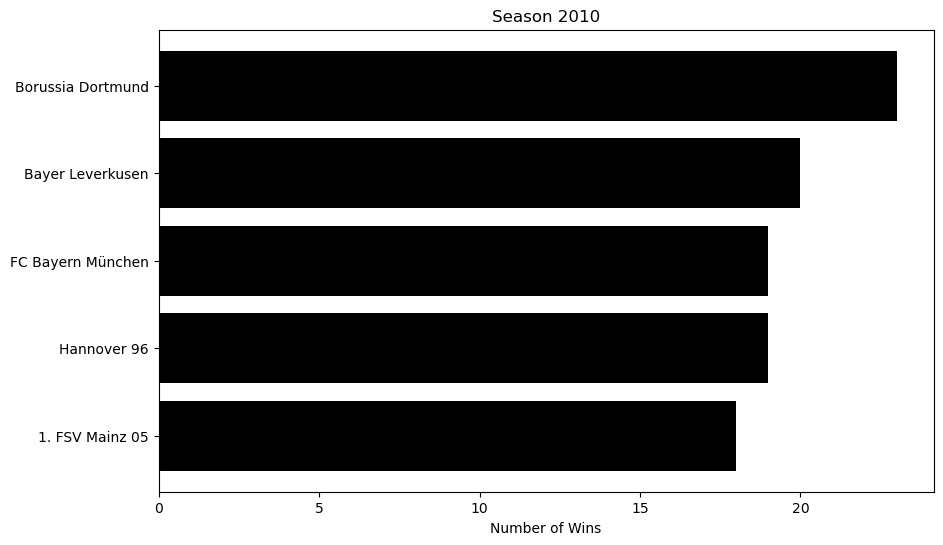

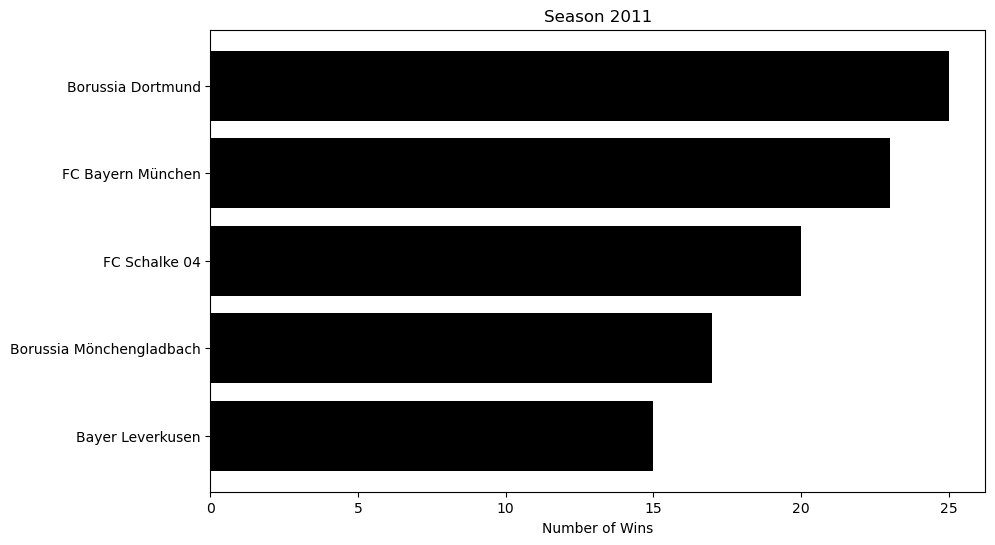

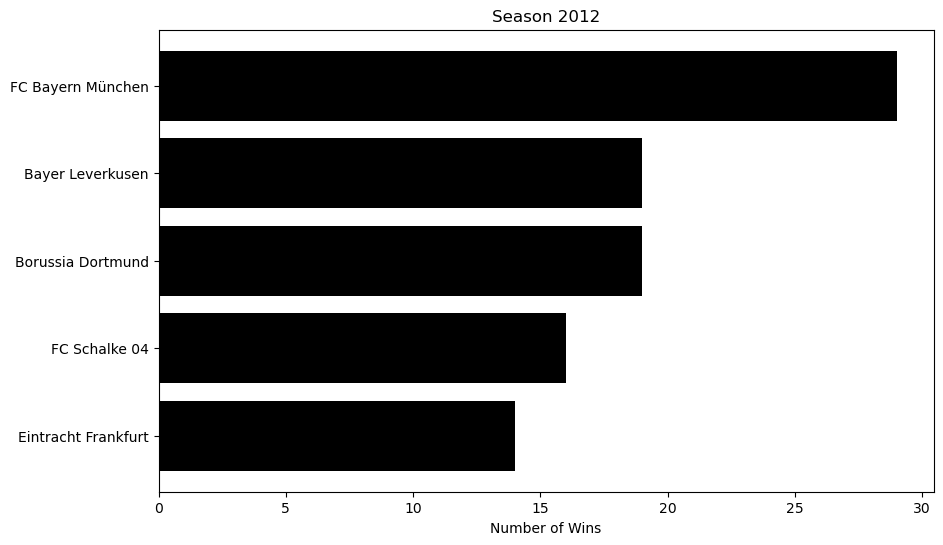

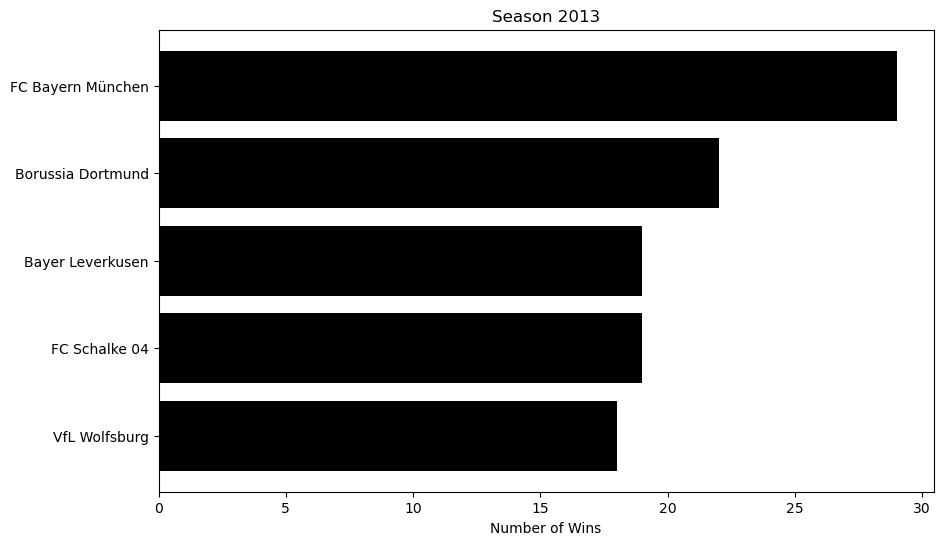

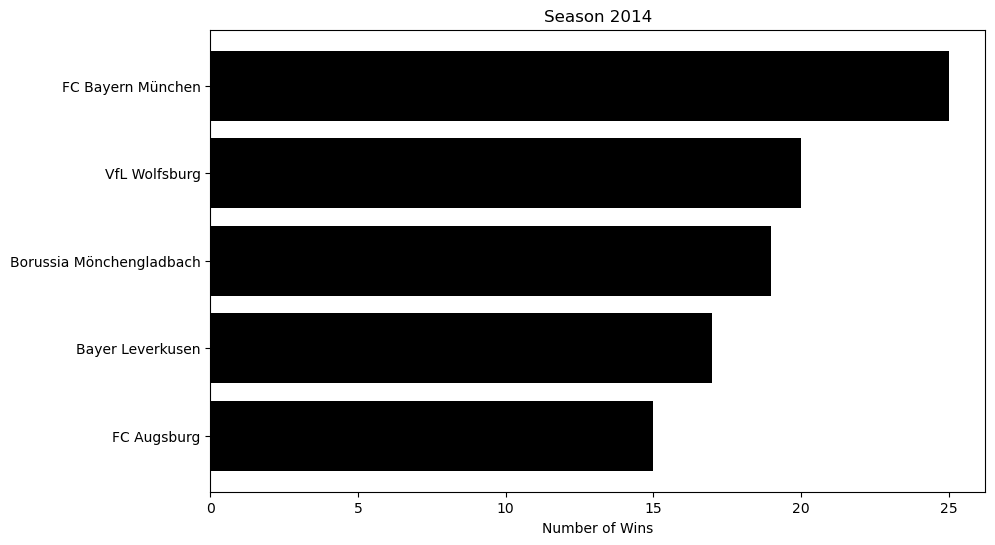

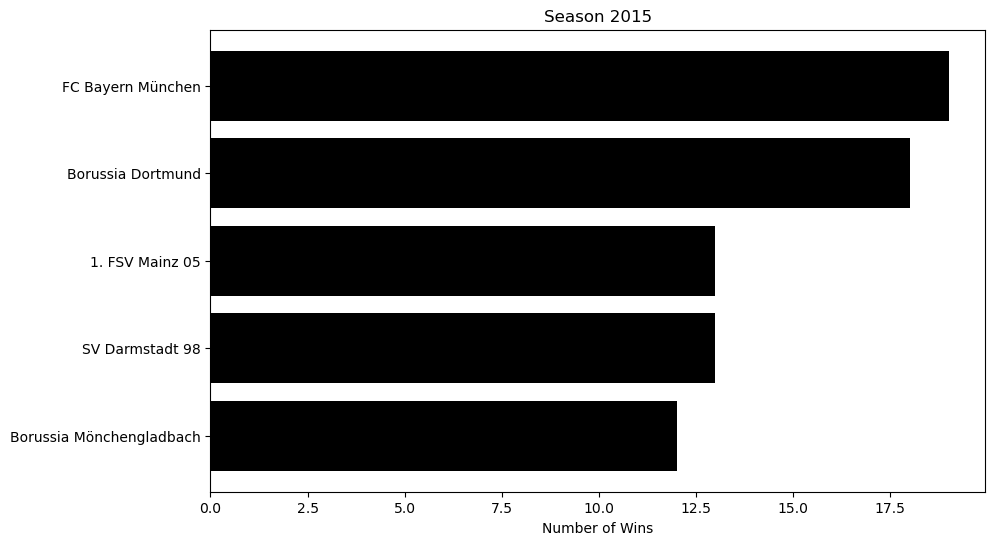

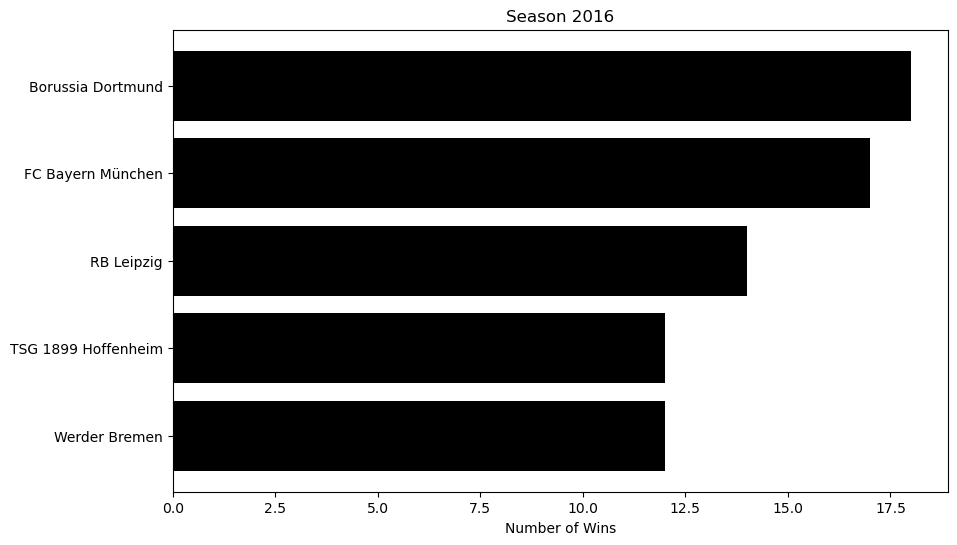

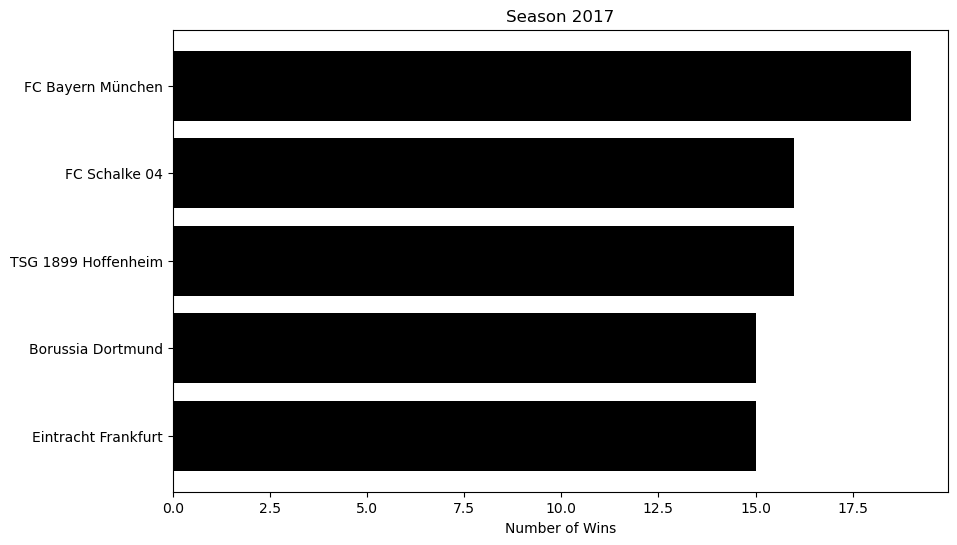

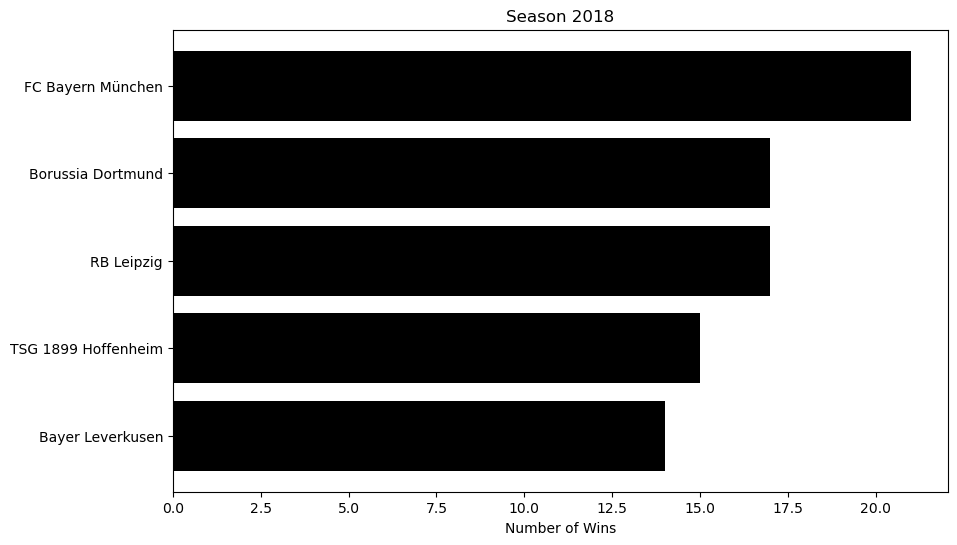

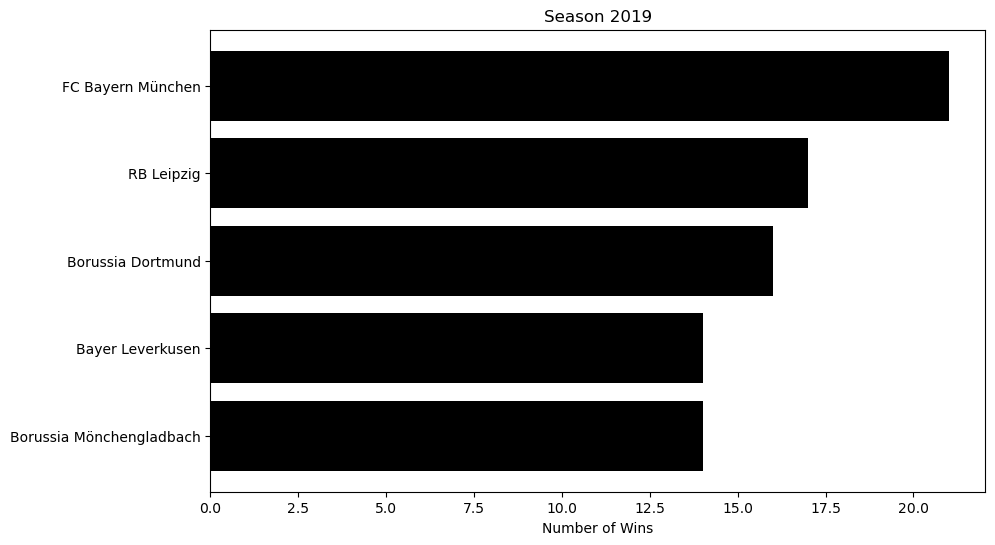

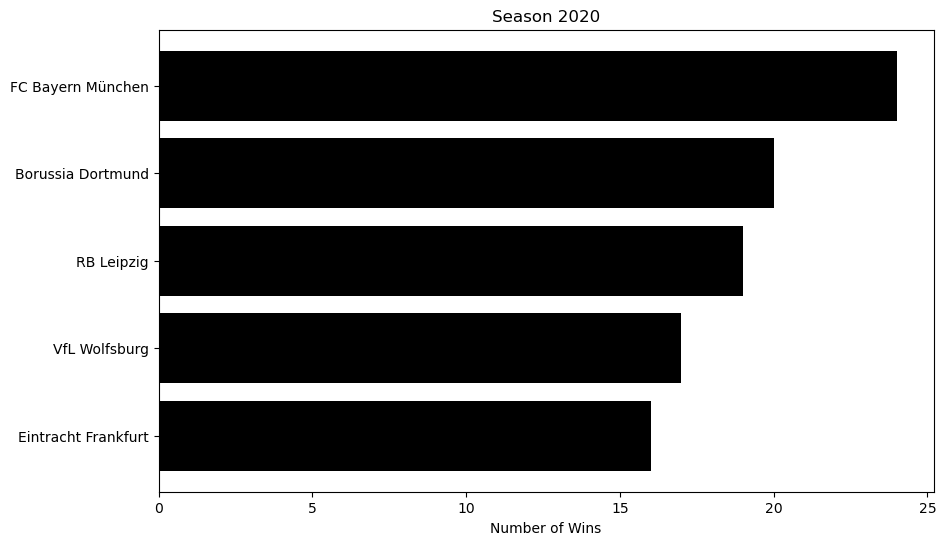

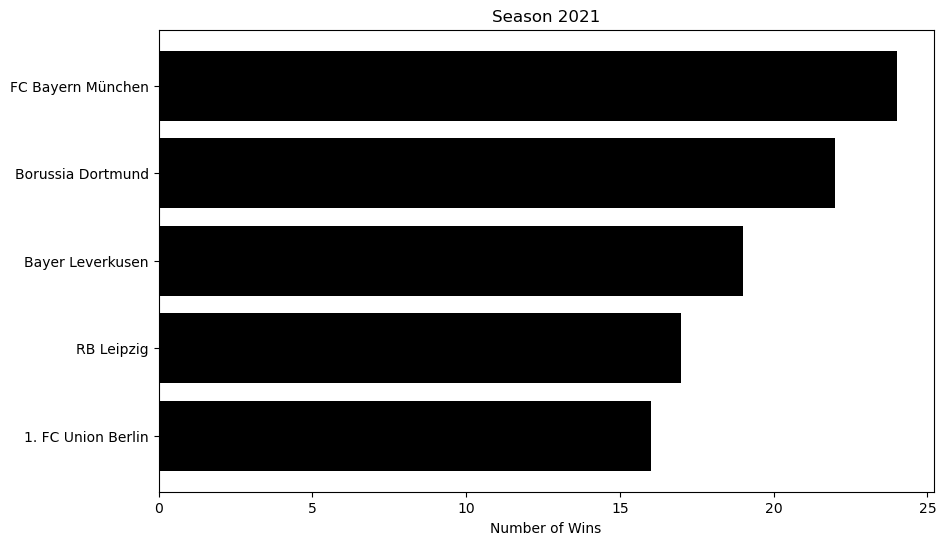

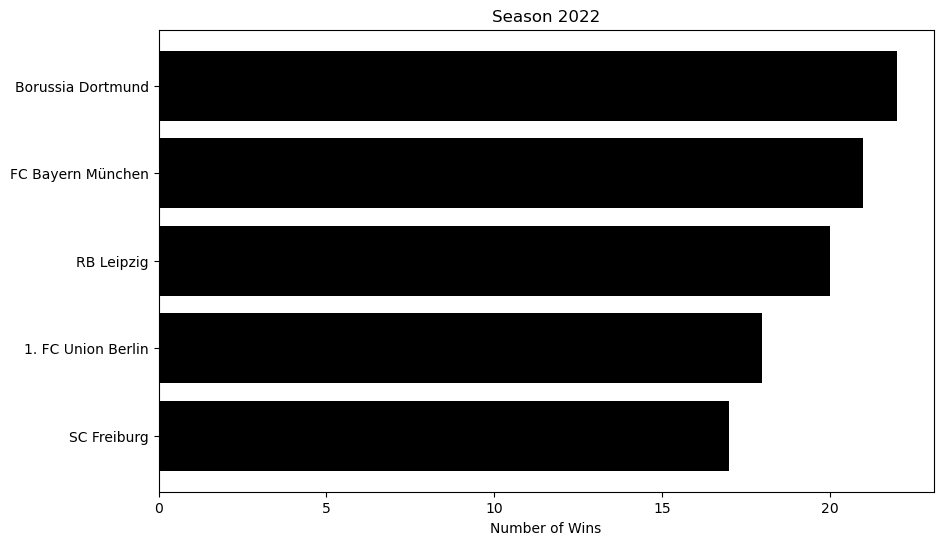

In [20]:
# Plotting
for season, group in top_5_teams.groupby('season'):
    plt.figure(figsize=(10,6))
    plt.barh(group['winning_team'], group['num_wins'], color='black')
    plt.xlabel('Number of Wins')
    plt.title(f'Season {season}')
    plt.gca().invert_yaxis()
    plt.show()

### Numericals

In [21]:
num_data = data.select_dtypes(include=['number'])
num_data.head()

,season,matchday_nr,home_team_id,away_team_id,goals_home,goals_away,draw,win_home,win_away,total_goals
0,2005,1,40,87,3,0,0.0,1.0,0.0,3
1,2005,1,65,81,1,0,0.0,1.0,0.0,1
2,2005,1,107,16,1,1,1.0,0.0,0.0,2
3,2005,1,100,79,3,0,0.0,1.0,0.0,3
4,2005,1,131,7,2,2,1.0,0.0,0.0,4


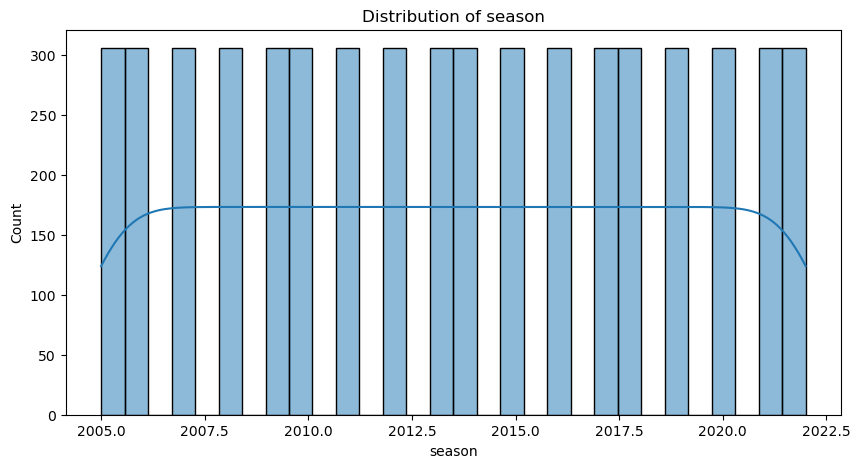

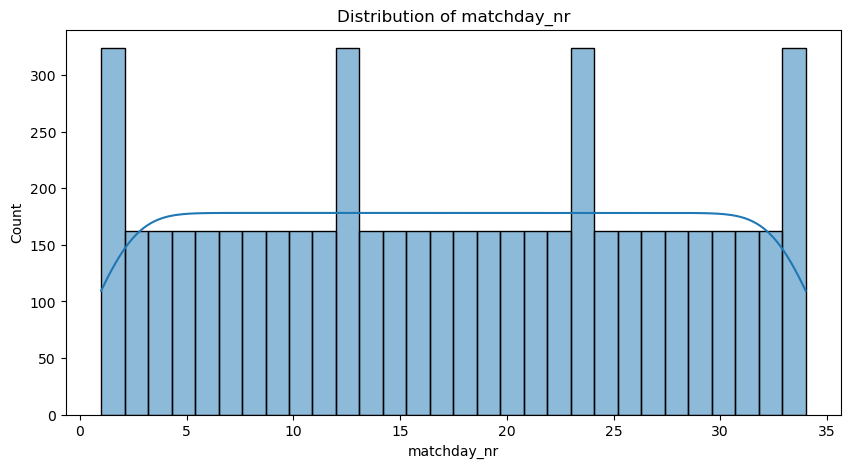

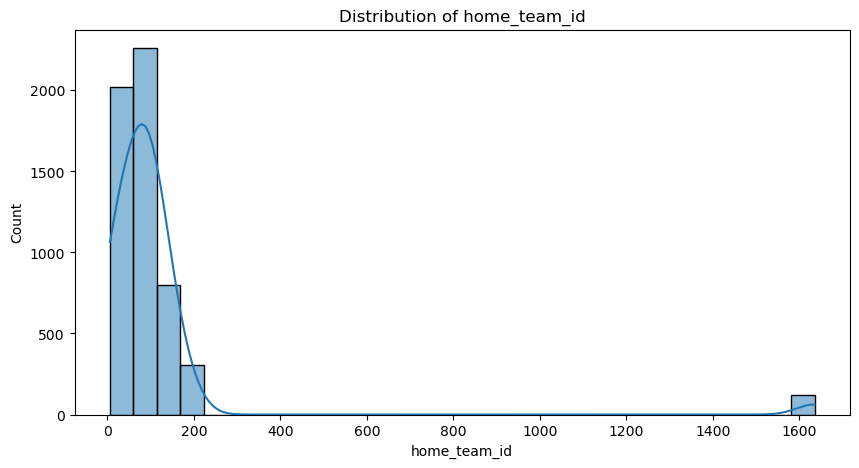

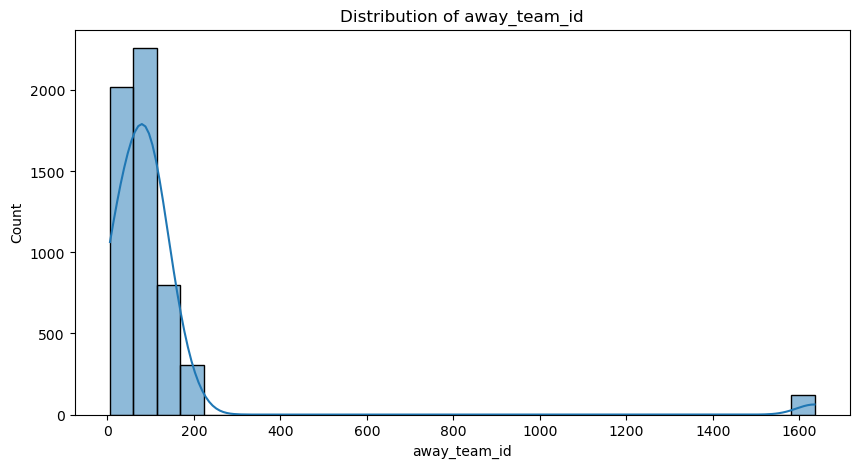

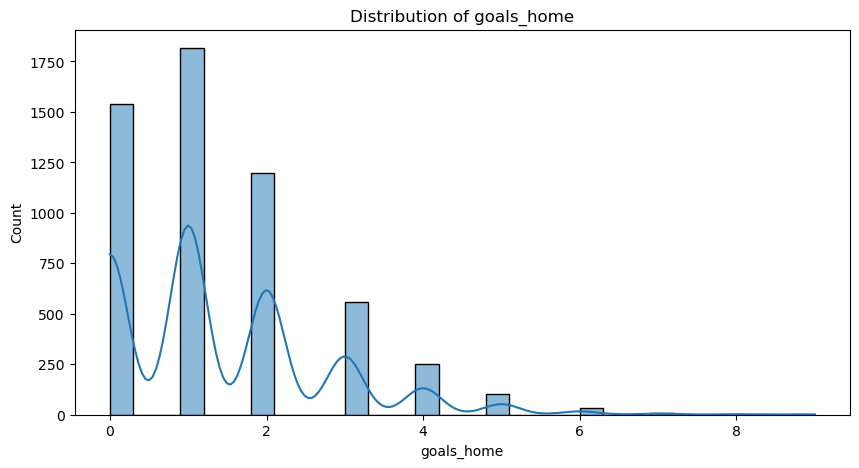

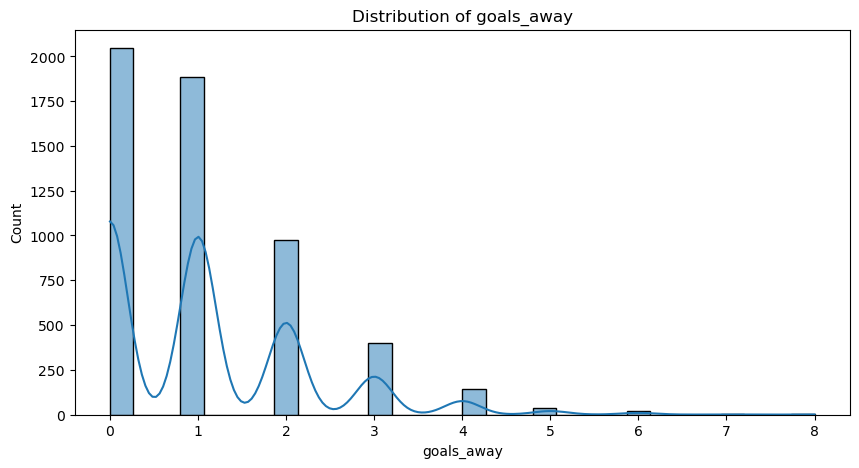

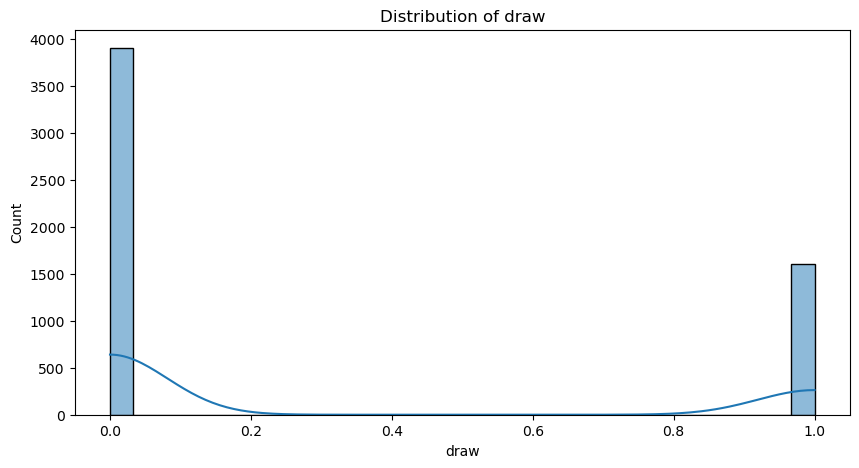

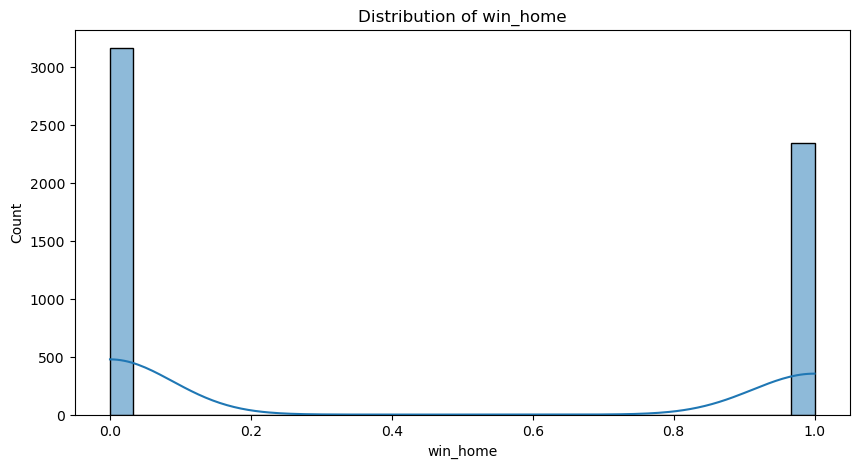

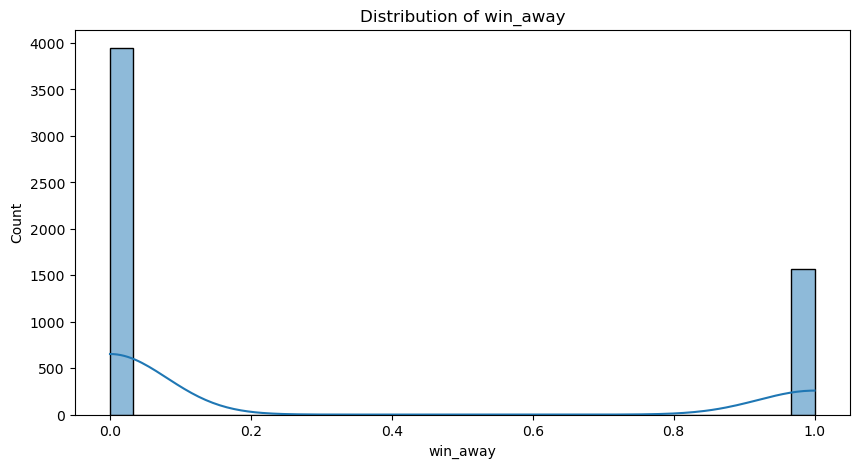

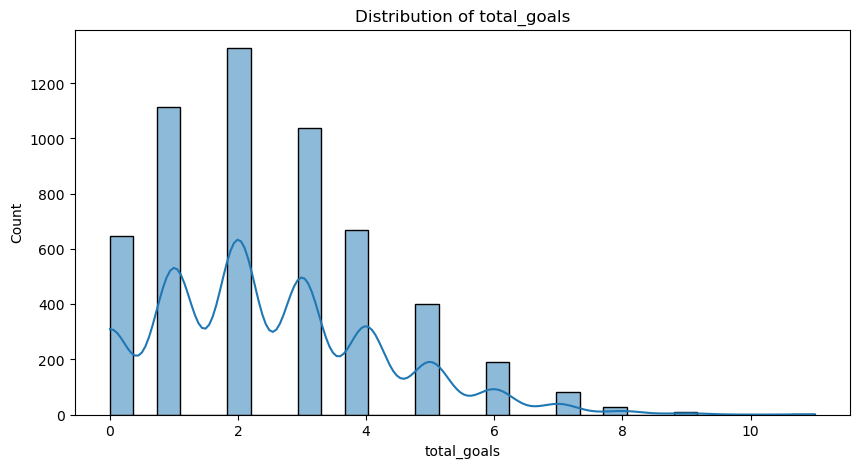

In [22]:
# Plot histograms for numerical columns
for col in num_data:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

- **season**: The data is uniformly distributed across seasons from 2005 to 2022. This indicates that we have roughly the same amount of data for each season.

- **matchday_nr**: The data is uniformly distributed, meaning we have roughly the same number of matches for each matchday from 1 to 34.

- **home_team_id** and **away_team_id**: These distributions are difficult to interpret due to the high number of unique team IDs. They would need to be linked with the actual team names to provide meaningful insights.

- **goals_home** and **goals_away**: Both of these distributions are right-skewed, with most matches having 0-2 goals and fewer matches having a high number of goals. This is a typical distribution for football matches, where low-scoring games are more common than high-scoring ones.

### Categoricals

In [23]:
cat_data = data.select_dtypes(include='object')
cat_data.head()

,location,home_team_name,away_team_name,outcome
0,München,FC Bayern München,Borussia Mönchengladbach,win_home
1,Köln,1. FC Köln,1. FSV Mainz 05,win_home
2,Duisburg,MSV Duisburg,VfB Stuttgart,draw
3,Hamburg,Hamburger SV,1. FC Nürnberg,win_home
4,Wolfsburg,VfL Wolfsburg,Borussia Dortmund,draw


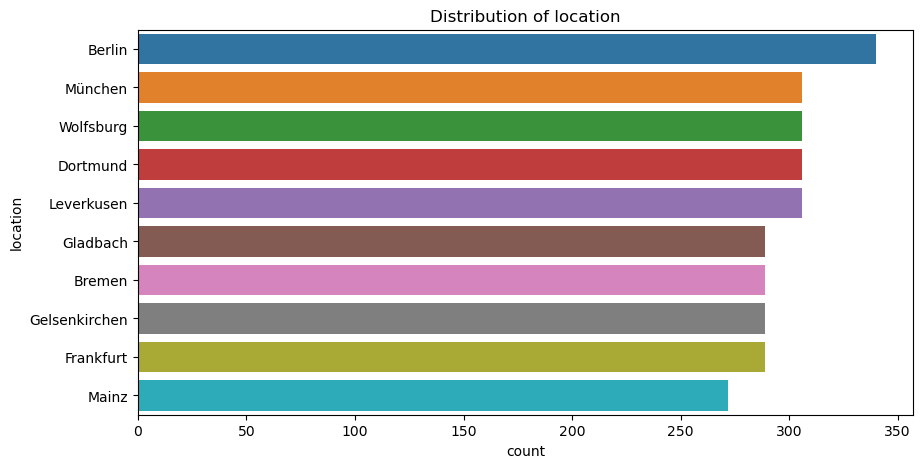

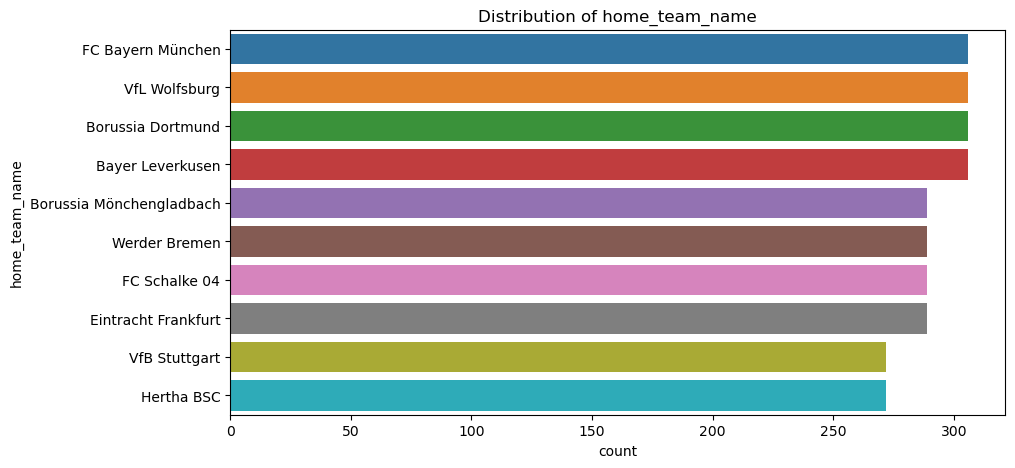

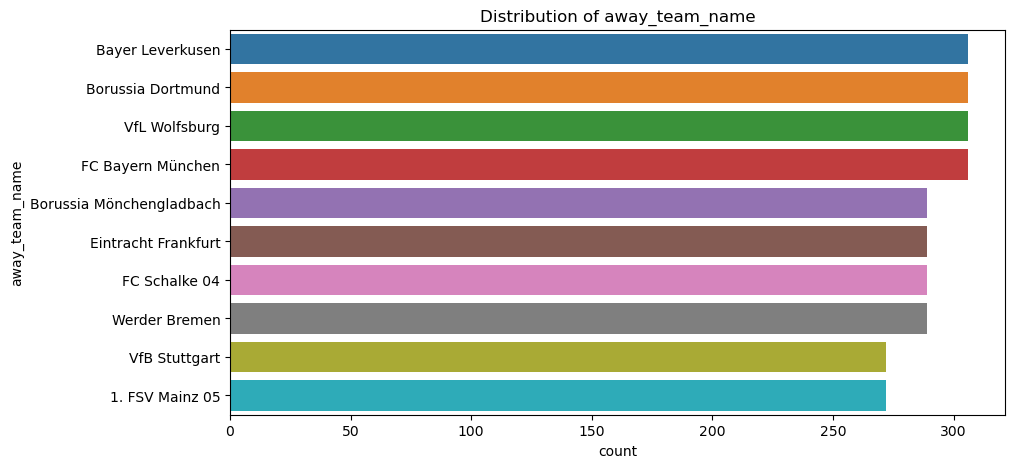

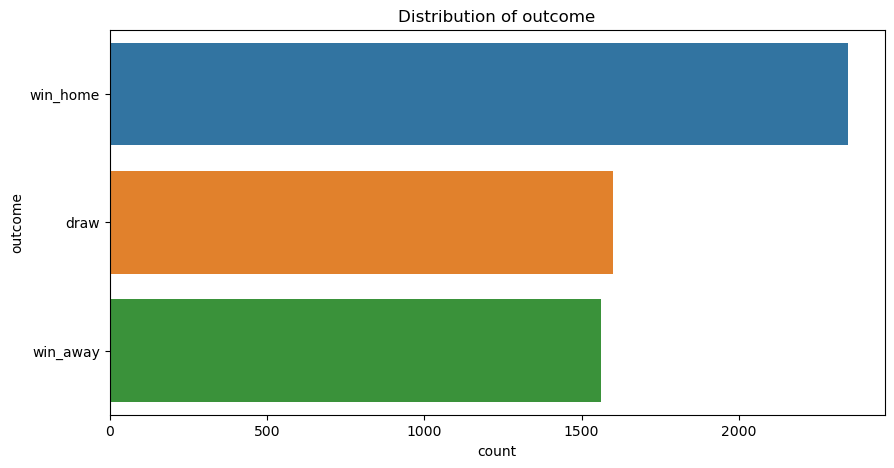

In [24]:
# Plot bar plots for categorical columns
for col in cat_data:
    plt.figure(figsize=(10, 5))
    
    # For high cardinality data, limit to top 10 values
    if col in ['location','home_team_name', 'home_team', 'away_team_name', 'away_team']:
        sns.countplot(data=data, y=col, order=data[col].value_counts().iloc[:10].index)
    else:
        sns.countplot(data=data, y=col)
    
    plt.title(f'Distribution of {col}')
    plt.show()

- **location**: The location of the matches is spread across various cities. The most common locations for matches are München, Dortmund, and Berlin.
- **home_team_name** & **away_team_name**: These distributions show the teams that played most often in the dataset. Bayern, Dortmund and Wolfsburg are among the teams that appear most frequently.

### Correlation

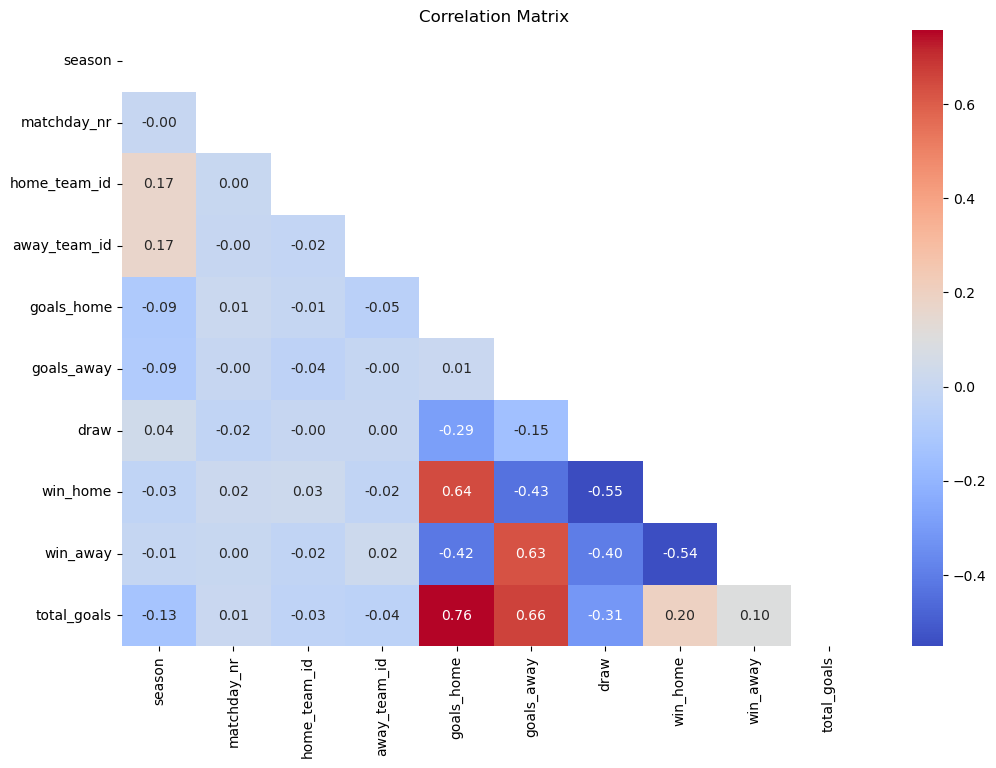

In [25]:
corr_matrix = num_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- **season** doesn't seem to have a strong correlation with any of the other variables, except of a low correlation with **home_team_id** and **away_team_id**.
- **matchday_nr** is not significantly correlated with any of the other variables.
- **home_team_id** and **away_team_id** have a small negative correlation. This might be due to how the teams are indexed; perhaps teams with lower IDs tend to play against teams with higher IDs more often, or vice versa. However, without more information about how these IDs are assigned, it's difficult to draw any definitive conclusions.
- It makes sense that **goals_away** and **win_away** as well as **goals_home** and **win_home** are highly correlated, since more goals increase the probability of a win.

<a href="#0"><font size="1">Go to top</font></a>  

# <a id='5'>Build a baseline model</a>

Next step in our creation of a predictive model is to create a simple model, a **baseline model**.  

**Why start with a simple model?**
 
With a simple model, we can get fast insight in how well will the data predict our target value. Looking at the training results (the training error and accuracy, the validation error and accuracy), we can understand if we need to add more data (because the training accuracy is small) or if we need to optimize the model etc.

For modeling, we need to do the following:

1. Define the target variable: Since we are trying to predict the outcome of a match, we can define the target as a categorical variable with three categories: home win, away win, and draw. To create this variable, we can convert the **win_home**, **win_away**, and **draw** columns into a single categorical column called **outcome**.

2. Split the data into training and testing sets: This is important to ensure that we can evaluate the model's performance on unseen data.

3. Choose a model: Given that we have a multiclass classification problem, potential models include logistic regression, decision trees, random forest, gradient boosting and others. We may also need to handle class imbalance if one outcome category is much more common than others.

4. Train the model: Fit the model to the data and tune any necessary hyperparameters.

5. Evaluate the model: Measure the model's performance using appropriate metrics (such as accuracy, precision, recall, or F1 score).

**Let's start by defining the target variable and splitting the data into training and testing sets.**

### Define Target Variable

In [26]:
# Summarize 'win_home', 'win_away', 'draw' to 'outcome'
data['outcome'] = data[['win_home', 'win_away', 'draw']].idxmax(axis=1)
data['outcome'].value_counts()

win_home    2345
draw        1601
win_away    1562
Name: outcome, dtype: int64

In [27]:
# Dropping 'win_home', 'win_away', 'draw'
data.drop(['win_home', 'win_away', 'draw'], axis=1, inplace=True)
data.head()

,season,location,matchday_nr,home_team_id,home_team_name,away_team_id,away_team_name,goals_home,goals_away,outcome,total_goals
0,2005,München,1,40,FC Bayern München,87,Borussia Mönchengladbach,3,0,win_home,3
1,2005,Köln,1,65,1. FC Köln,81,1. FSV Mainz 05,1,0,win_home,1
2,2005,Duisburg,1,107,MSV Duisburg,16,VfB Stuttgart,1,1,draw,2
3,2005,Hamburg,1,100,Hamburger SV,79,1. FC Nürnberg,3,0,win_home,3
4,2005,Wolfsburg,1,131,VfL Wolfsburg,7,Borussia Dortmund,2,2,draw,4


I've created a new target variable named **outcome**, which is a categorical variable with three categories: 'win_home', 'win_away', 'draw'. The new target variable has the following distribution:

- **home_win**: 2345 instances
- **draw**: 1601 instances
- **away_win**: 1562 instances

This distribution is fairly balanced, so we may not need to do any additional handling for class imbalance.

## <a id='51'>LogisticRegression</a>

### Select Features

In [28]:
features = data[['season', 'matchday_nr', 'home_team_id', 'away_team_id']]

I selected the following feature columns to use for the prediction: **'season'**, **'matchday_nr'**, **'home_team_id'** and **'away_team_id'**. Note that this is a simple selection for an initial model and there are many other features one could engineer but that would require additional data.

### X-Y Split

In [29]:
X = features
y = data['outcome']

### Train-Test Split

In [30]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now that we have our training and testing data, we can move on to the model selection and training stage.

Given that we have a multiclass classification problem, we can start with a simple model like logistic regression. Even though logistic regression is traditionally used for binary classification tasks, it can be extended to multiclass classification.

Let's train a logistic regression model on our training data. We'll use the one-vs-rest (OvR) approach, which involves training a single classifier per class, with the samples of that class as positive samples and all other samples as negatives.

In [31]:
# Create a Logistic Regression model
logreg = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)

In [32]:
# Train the model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42)

In [33]:
# Estimate the model performance using cross-validation on the training data
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5)

In [34]:
# Predict the outcomes on the testing data
predictions_log = logreg.predict(X_test)

Finally, we'll evaluate the model on the testing data to see how well it generalizes to new, unseen data. The main metrics we'll use for evaluation are **accuracy**, **precision**, **recall**, and **F1 score**. For multiclass classification, these metrics are typically averaged over all classes. 

Precision is the proportion of true positive predictions (correct predictions of a class) among all positive predictions. Recall (or sensitivity) is the proportion of true positive predictions among all actual positives. F1 score is the harmonic mean of precision and recall, providing a balance between these two metrics. Accuracy is the proportion of correct predictions among all predictions.

In [35]:
# Show classification report
print(classification_report(y_test, predictions_log))

              precision    recall  f1-score   support

        draw       0.00      0.00      0.00       316
    win_away       0.35      0.03      0.05       316
    win_home       0.43      0.98      0.60       470

    accuracy                           0.43      1102
   macro avg       0.26      0.34      0.21      1102
weighted avg       0.28      0.43      0.27      1102



In [36]:
cv_scores

array([0.430839  , 0.42678774, 0.42565267, 0.42565267, 0.42224745])

In [37]:
pd.Series(predictions_log).value_counts()

win_home    1079
win_away      23
dtype: int64

In [38]:
y_test.value_counts()

win_home    470
win_away    316
draw        316
Name: outcome, dtype: int64

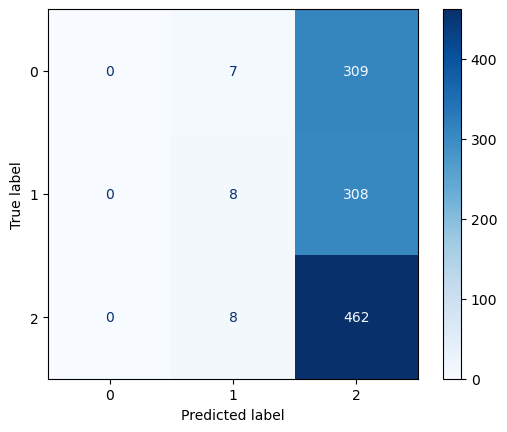

In [39]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions_log)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

### Feature Importance

#### Get the feature importance for the Logistic Regression model

In [40]:
# For logistic regression, the feature importance is based on the coefficients of the features
log_reg_coef = logreg.coef_[0]

# Create a pandas series with the coefficients
log_reg_feature_importance = pd.Series(log_reg_coef, index=X_train.columns)

# Display the feature importance
log_reg_feature_importance.sort_values(ascending=False)

away_team_id   -0.000015
home_team_id   -0.000066
season         -0.000418
matchday_nr    -0.002163
dtype: float64

### Present results

The classification report on the testing data shows:

For **draw**, the precision, recall, and F1-score are all 0. This means the model is not predicting any draws at all.

For **win_away**, the precision is 0.35, recall is 0.03, and F1-score is 0.05. This means the model is rarely predicting away wins, and when it does, it's correct about 35% of the time.

For **win_home**, the precision is 0.43, recall is 0.98, and F1-score is 0.60. This means the model is mostly predicting home wins, and it's correct about 43% of the time.

The overall accuracy on the testing data is 0.43, meaning the model is correct about 43% of the time on unseen data.

These results suggest that the model is biased towards predicting home wins, likely because home wins are the most common outcome in the data. This is a common issue in machine learning known as class imbalance, where the model is biased towards the majority class. A potential solution is to use a model that can handle class imbalance, or to artificially balance the classes by oversampling the minority classes or undersampling the majority class.

Another potential issue is that the features we're using may not be sufficient to accurately predict the outcome of a match. In reality, the outcome of a football match is determined by numerous factors, many of which are not included in our data. Some potential useful features could be team rankings, player statistics, team form (results of recent matches), injuries, etc.

## <a id='52'>RandomForestClassifier</a>

In [41]:
# Define a simpler grid of hyperparameters to search
simple_hyperparameter_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
}

rf = RandomForestClassifier(random_state=42)

In [42]:
# Set up the grid search with the simpler grid
simple_grid_cv = GridSearchCV(rf, simple_hyperparameter_grid, cv=5)

In [43]:
# Perform the grid search
simple_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10], 'n_estimators': [100, 200]})

In [44]:
# Get the best parameters
best_params_simple = simple_grid_cv.best_params_

In [45]:
# Train a random forest classifier with the best parameters
rf_best_simple = RandomForestClassifier(n_estimators=best_params_simple['n_estimators'], 
                                        max_depth=best_params_simple['max_depth'], 
                                        random_state=42)

rf_best_simple.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

In [46]:
# Predict the outcomes on the testing data
predictions_rf = rf_best_simple.predict(X_test)

In [47]:
# Show classification report
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

        draw       0.40      0.20      0.27       316
    win_away       0.45      0.28      0.34       316
    win_home       0.48      0.77      0.59       470

    accuracy                           0.46      1102
   macro avg       0.44      0.42      0.40      1102
weighted avg       0.45      0.46      0.43      1102



In [48]:
# Estimate the model performance using cross-validation on the training data
cv_scores = cross_val_score(simple_grid_cv, X_train, y_train, cv=5)
cv_scores

array([0.49206349, 0.47332577, 0.47559591, 0.45856981, 0.46538025])

In [49]:
pd.Series(predictions_rf).value_counts()

win_home    746
win_away    195
draw        161
dtype: int64

In [50]:
y_test.value_counts()

win_home    470
win_away    316
draw        316
Name: outcome, dtype: int64

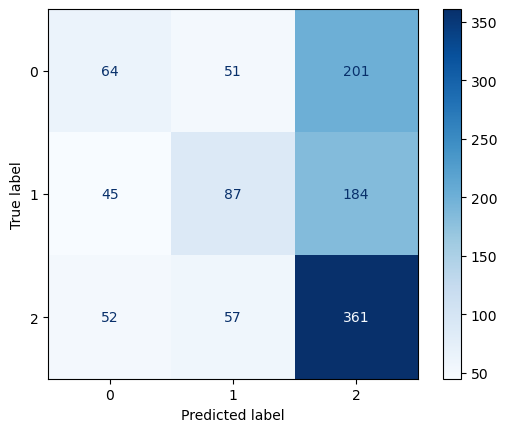

In [51]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions_rf)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

### Feature Importance

#### Get the feature importance for the RandomForest model

In [52]:
# For RandomForest, we can use the feature_importances_ attribute
rf_feature_importance = rf_best_simple.feature_importances_

# Create a pandas series with the feature importances
rf_feature_importance = pd.Series(rf_feature_importance, index=X_train.columns)

# Display the feature importance
rf_feature_importance.sort_values(ascending=False)

home_team_id    0.345174
away_team_id    0.317764
season          0.211454
matchday_nr     0.125608
dtype: float64

### Present results

The Random Forest model with the best parameters (n_estimators = 200, max_depth = 5) achieved an accuracy of 0.46 on the testing data, which is an improvement over the logistic regression model. The precision, recall, and F1-score for each class are also more balanced than before, although they are still not very high. Here's the breakdown:

For **draw**, the precision is 0.40, recall is 0.20, and F1-score is 0.27. This means that when the model predicts a draw, it is correct about 40% of the time. However, it only correctly predicts about 20% of the actual draws.

For **win_away**, the precision is 0.45, recall is 0.28, and F1-score is 0.34. This means that when the model predicts an away win, it is correct about 45% of the time. However, it only correctly predicts about 28% of the actual away wins.

For **win_home**, the precision is 0.48, recall is 0.77, and F1-score is 0.59. This means that when the model predicts a home win, it is correct about 48% of the time. In addition, it correctly predicts about 77% of the actual home wins.

These results indicate that the model is still somewhat biased towards predicting home wins, but less so than the logistic regression model. The performance on draws and away wins is also somewhat improved, although it is still not very high.

## <a id='53'>Gradient Boosting (using XGBoost)</a>

In [53]:
# Create and train the model
model = XGBClassifier(use_label_encoder=False)

The XGBoost model requires the labels to be in a specific format - it expects the classes to be labelled as 0, 1, 2. As a workaround, we can encode the labels of the target variable using the LabelEncoder class from scikit-learn. This class will transform the categorical labels in the target variable into integers.

In [54]:
# Create a label encoder object
le = LabelEncoder()

# Fit the encoder to the 'y' data
y_encoded = le.fit_transform(y)

### Train-Test Split

In [55]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [56]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [57]:
# Predict the outcomes on the test set
y_pred = model.predict(X_test)

In [58]:
# Show classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.28      0.29       316
           1       0.33      0.29      0.31       316
           2       0.50      0.57      0.53       470

    accuracy                           0.41      1102
   macro avg       0.38      0.38      0.38      1102
weighted avg       0.40      0.41      0.40      1102



In [59]:
pd.Series(y_pred).value_counts()

2    536
0    283
1    283
dtype: int64

In [60]:
pd.Series(y_test).value_counts()

2    470
1    316
0    316
dtype: int64

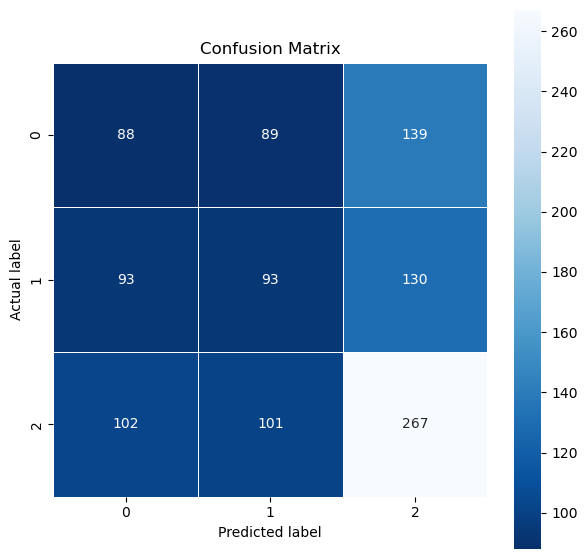

In [61]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix');

### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

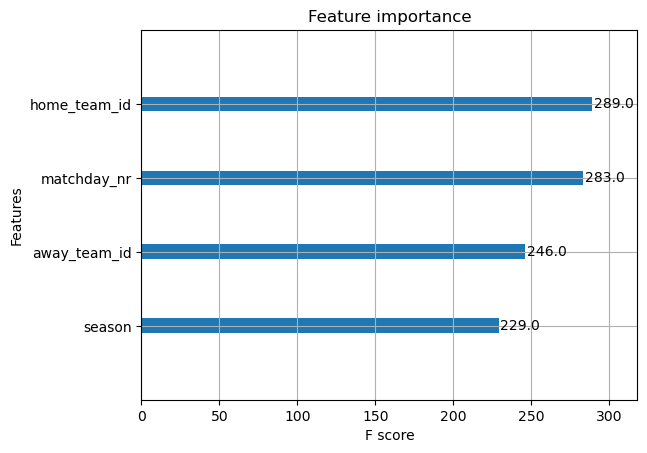

In [62]:
# To get feature importances for XGBoost, we first need to create a DMatrix object for the data
# This is a requirement for using the plot_importance function
import xgboost as xgb

# Create DMatrix for train and test
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify parameters via map, definition are same as c++ version
param = {'max_depth':3, 'eta':0.3, 'objective':'multi:softprob', 'num_class':3}

# Train the model using a small number of boosting rounds and the early stopping feature
# This will prevent overfitting and reduce the chance of running out of memory
num_round = 50
bst = xgb.train(param, dtrain, num_round)

# Plot feature importances
xgb.plot_importance(bst)

### Present results

The Gradient Boosting model using XGBoost has an accuracy of 0.41 on the testing data, which is slightly lower than the accuracy of the Random Forest model (0.46) and very similar to the logistic regression model.

For **draw** (class 0), the precision is 0.31, recall is 0.28, and F1-score is 0.29. This means that when the model predicts a draw, it is correct about 31% of the time. However, it only correctly predicts about 28% of the actual draws.

For **win_away** (class 1), the precision is 0.33, recall is 0.29, and F1-score is 0.31. This means that when the model predicts an away win, it is correct about 33% of the time. However, it only correctly predicts about 29% of the actual away wins.

For **win_home** (class 2), the precision is 0.50, recall is 0.57, and F1-score is 0.53. This means that when the model predicts a home win, it is correct about 50% of the time. In addition, it correctly predicts about 57% of the actual home wins.

Compared to the Random Forest model, the Gradient Boosting model performs worse in predicting draws and away wins, but it performs better in predicting home wins. This suggests that the Gradient Boosting model, like the other models, is biased towards predicting home wins, likely because home wins are the most common outcome in the data.

Compared to the logistic regression model, the Gradient Boosting model performs significantly better on all metrics for all classes. This suggests that the Gradient Boosting model is able to capture more complex patterns in the data that the logistic regression model is missing.

Overall, while the Gradient Boosting model performs better than the logistic regression model, it still struggles with class imbalance and is heavily biased towards predicting home wins.

## <a id='54'>K-nearest neighbours</a>

In [63]:
# List of possible n_neighbors to try
n_neighbors = list(range(1, 31))

In [64]:
# List to store the average cross-validation score for each value of n_neighbors
cv_scores = []

In [65]:
# Perform 5-fold cross-validation for each value of n_neighbors
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

In [66]:
# Determine the best n_neighbors
best_n_neighbors = n_neighbors[cv_scores.index(max(cv_scores))]

best_n_neighbors, max(cv_scores)

(19, 0.4271424195860713)

In [67]:
# Train the KNN model on the training data
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=19)

In [68]:
# Make predictions on the test data
y_pred = knn.predict(X_test)

In [69]:
# Show classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.26      0.20      0.23       316
           1       0.42      0.39      0.40       316
           2       0.49      0.60      0.54       470

    accuracy                           0.42      1102
   macro avg       0.39      0.39      0.39      1102
weighted avg       0.41      0.42      0.41      1102



In [70]:
# Estimate the model performance using cross-validation on the training data
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
cv_scores

array([0.43764172, 0.43246311, 0.41884222, 0.39954597, 0.44721907])

In [71]:
pd.Series(y_pred).value_counts()

2    570
1    292
0    240
dtype: int64

In [72]:
pd.Series(y_test).value_counts()

2    470
1    316
0    316
dtype: int64

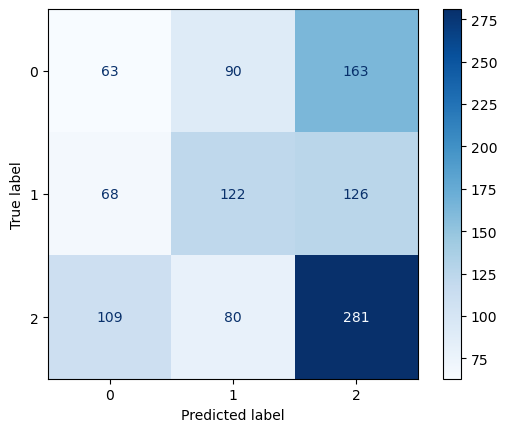

In [73]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

### Feature Importance

In [74]:
# Fit a KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Compute permutation feature importance
perm_importance = permutation_importance(knn, X_test, y_test)

# Create a pandas series with the feature importances
knn_feature_importance = pd.Series(perm_importance.importances_mean, index=X_train.columns)

# Display the feature importance
knn_feature_importance.sort_values(ascending=False)

home_team_id    0.011071
away_team_id    0.009800
matchday_nr    -0.015064
season         -0.015971
dtype: float64

The K-Nearest Neighbors model (KNN), with n=19, has an accuracy of 0.42 on the testing data. This is similar to the performance of the Gradient Boosting model (0.41), slightly less than the Random Forest model (0.46), but slightly better than the Logistic Regression model (0.43).

For **draw** (class 0), the KNN model has a precision of 0.26 and recall of 0.20. Both of these values are higher than the corresponding values for the Logistic Regression model (precision 0.00, recall 0.00), but lower than those for the Gradient Boosting model (precision and recall values not provided in the comparison).

For **win_away** (class 1), the KNN model has a precision of 0.42 and recall of 0.39. These values are higher than the corresponding values for both the Logistic Regression model (precision 0.35, recall 0.03) and the Gradient Boosting model (precision and recall values not provided in the comparison).

For **win_home** (class 2), the KNN model has a precision of 0.49 and recall of 0.60. These values are higher than those of the Logistic Regression model (precision 0.43, recall 0.98), but the recall value is lower.

In comparison to the other models, the KNN model performs better in predicting 'win_away' games, but not as well in predicting 'draw' games. It has comparable performance for predicting 'win_home' games.

In summary, the choice of model may depend on the specific requirements of the task. If predicting 'win_away' games is particularly important, the KNN model may be the best choice among the models. However, if overall accuracy or the prediction of 'draw' games is more important, the Random Forest model or Gradient Boosting model might be more appropriate.

## How to improve the model?

**Collect more data**: For example enriching "viewer" column trough webscraping or looking for another way of finding data.

**Handle class imbalance**: As I mentioned earlier, our target variable is imbalanced, with more instances of home wins than draws or away wins. We can try to balance the classes by oversampling the minority classes (i.e., creating copies of some instances), undersampling the majority class (i.e., deleting some instances), or using a combination of both. We can also try using a model that can handle class imbalance internally, such as a decision tree-based model.

**Feature engineering**: We can create new features that might be predictive of the target variable. However, this usually requires additional data.

**Data preprocessing**: Some models may perform better if the data is preprocessed in a certain way. For example, standardizing the features (i.e., scaling them to have a mean of 0 and a standard deviation of 1) can improve the performance of models like SVMs and neural networks.

**Model selection and hyperparameter tuning**: We can try more models and tune their hyperparameters.

# <a id='6'>Model refinement</a> 

Model refinement is a crucial step in the data science pipeline that aims to improve the performance of predictive models. It's often the case that the initial model you build doesn't perform optimally, and it may need adjustments or 'refinements' to improve its predictive accuracy, precision, recall, F1 score, or any other performance metric that you're using.

## <a id='61'>Preprocessing</a>

### Scaling

In [75]:
# Let's preprocess 'season' and 'matchday_nr' using standardization

# Create the transformer
#scaler = StandardScaler()

In [76]:
# Fit the transformer and transform the data
#season_scaled = scaler.fit_transform(data[['season']])
#matchday_nr_scaled = scaler.fit_transform(data[['matchday_nr']])

In [77]:
# The transformed data is a numpy array, let's convert it back to a dataframe for easier viewing
#season_scaled_df = pd.DataFrame(season_scaled, columns=['season'])
#matchday_nr_scaled_df = pd.DataFrame(matchday_nr_scaled, columns=['matchday_nr'])

In [78]:
# Let's look at the first few rows of the transformed data
#season_scaled_df.head(), matchday_nr_scaled_df.head()

Scaling had no positive influence on the model

<a href="#0"><font size="1">Go to top</font></a>  

## <a id='62'>Feature Engineering Part 1</a>

In [79]:
# Create GOAL_DIFFERENCE feature
#data['goal_difference'] = data['goals_home'] - data['goals_away']

I create a new feature called **goal_difference** that might be useful for the modeling stage and is the difference between **goals_home** and **goals_away**. This can capture the relative performance of the home team vs. the away team in a single feature.

## Modelling including "goal_difference"

### Select Features

In [80]:
#features = data[['season', 'matchday_nr', 'home_team_id', 'away_team_id', 'goal_difference']]

### X-Y Split

In [81]:
#X = features
#y = data['outcome']

### Train-Test Split

In [82]:
# Split the data into a training set and a test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
# Create a Logistic Regression model
#logreg = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)

In [84]:
# Train the model
#logreg.fit(X_train, y_train)

In [85]:
# Estimate the model performance using cross-validation on the training data
#cv_scores = cross_val_score(logreg, X_train, y_train, cv=5)

In [86]:
# Predict the outcomes on the testing data
#predictions = logreg.predict(X_test)

### Check how well the model performs

In [87]:
# Classification report
#class_report = classification_report(y_test, predictions)
#class_report

In [88]:
#cv_scores

### Present the results

The model has achieved perfect accuracy, precision, recall, and F1-score on both the training data (as indicated by the cross-validation scores) and the testing data. This is highly unusual and could indicate a data leakage issue, where the model is indirectly given the answer because of how the features are defined.

Upon reviewing the features, it's clear that the goal_difference is the source of the leakage. goal_difference is calculated based on the goals scored by each team, which directly determines the outcome of the match. Therefore, when this feature is included, the model is essentially being given the answer.

In a real-world prediction scenario, we wouldn't know the goal_difference ahead of time because the goals haven't been scored yet. Therefore, we need to remove this feature (I will leave it in the notebook and comment it out).

## <a id='63'>Feature Engineering Part 2</a>

I will add a new data set to have more features, hopefully resulting in a better model.

In [89]:
# Load the merged_df
merged_df = pd.read_csv('merged_df_cleaned.csv')
merged_df

,matchday_nr,home_team_name,away_team_name,hist_home_team_win,hist_draw,hist_away_team_win,hist_goal_dif,season
0,1,Eintracht Frankfurt,FC Bayern München,24.0,22.0,56.0,-80.0,2022
1,1,Borussia Dortmund,Bayer Leverkusen,36.0,22.0,30.0,19.0,2022
2,1,1. FC Union Berlin,Hertha BSC,4.0,3.0,3.0,0.0,2022
3,1,1. FC Köln,FC Schalke 04,39.0,22.0,27.0,27.0,2022
4,1,Borussia Mönchengladbach,TSG 1899 Hoffenheim,8.0,12.0,10.0,6.0,2022
...,...,...,...,...,...,...,...,...
4891,34,Hannover 96,FC Energie Cottbus,4.0,0.0,4.0,-1.0,2008
4892,34,Borussia Dortmund,VfL Wolfsburg,12.0,7.0,3.0,18.0,2008
4893,34,Hamburger SV,Karlsruher SC,15.0,17.0,12.0,14.0,2008
4894,34,VfL Bochum,FC Hansa Rostock,7.0,4.0,9.0,-3.0,2008


The dataset contains the following columns:

- **matchday_nr**: The matchday number in the league.

- **home_team_name**: The name of the team playing at home.

- **away_team_name**: The name of the team playing away.

- **hist_home_team_win**: The historical number of times the home team has won when these two teams have faced each other.

- **hist_draw**: The historical number of times the game has ended in a draw when these two teams have faced each other.

- **hist_away_team_win**: The historical number of times the away team has won when these two teams have faced each other.

- **hist_goal_dif**: The historical goal difference between the two teams. A positive value indicates that the home team has scored more goals than the away team in their historical matchups, while a negative value indicates the opposite.

- **season**: The year of the season.

**Now i will merge both data sets to finally see, if the model improves.**

In [90]:
merged_df['identifier'] = merged_df['season'].astype(str) + "_" + merged_df['home_team_name'] + "_" + merged_df['away_team_name']
merged_df

,matchday_nr,home_team_name,away_team_name,hist_home_team_win,hist_draw,hist_away_team_win,hist_goal_dif,season,identifier
0,1,Eintracht Frankfurt,FC Bayern München,24.0,22.0,56.0,-80.0,2022,2022_Eintracht Frankfurt_FC Bayern München
1,1,Borussia Dortmund,Bayer Leverkusen,36.0,22.0,30.0,19.0,2022,2022_Borussia Dortmund_Bayer Leverkusen
2,1,1. FC Union Berlin,Hertha BSC,4.0,3.0,3.0,0.0,2022,2022_1. FC Union Berlin_Hertha BSC
3,1,1. FC Köln,FC Schalke 04,39.0,22.0,27.0,27.0,2022,2022_1. FC Köln_FC Schalke 04
4,1,Borussia Mönchengladbach,TSG 1899 Hoffenheim,8.0,12.0,10.0,6.0,2022,2022_Borussia Mönchengladbach_TSG 1899 Hoffenheim
...,...,...,...,...,...,...,...,...,...
4891,34,Hannover 96,FC Energie Cottbus,4.0,0.0,4.0,-1.0,2008,2008_Hannover 96_FC Energie Cottbus
4892,34,Borussia Dortmund,VfL Wolfsburg,12.0,7.0,3.0,18.0,2008,2008_Borussia Dortmund_VfL Wolfsburg
4893,34,Hamburger SV,Karlsruher SC,15.0,17.0,12.0,14.0,2008,2008_Hamburger SV_Karlsruher SC
4894,34,VfL Bochum,FC Hansa Rostock,7.0,4.0,9.0,-3.0,2008,2008_VfL Bochum_FC Hansa Rostock


In [91]:
data['identifier'] = data['season'].astype(str) + "_" + data['home_team_name'] + "_" + data['away_team_name']
data

,season,location,matchday_nr,home_team_id,home_team_name,away_team_id,away_team_name,goals_home,goals_away,outcome,total_goals,identifier
0,2005,München,1,40,FC Bayern München,87,Borussia Mönchengladbach,3,0,win_home,3,2005_FC Bayern München_Borussia Mönchengladbach
1,2005,Köln,1,65,1. FC Köln,81,1. FSV Mainz 05,1,0,win_home,1,2005_1. FC Köln_1. FSV Mainz 05
2,2005,Duisburg,1,107,MSV Duisburg,16,VfB Stuttgart,1,1,draw,2,2005_MSV Duisburg_VfB Stuttgart
3,2005,Hamburg,1,100,Hamburger SV,79,1. FC Nürnberg,3,0,win_home,3,2005_Hamburger SV_1. FC Nürnberg
4,2005,Wolfsburg,1,131,VfL Wolfsburg,7,Borussia Dortmund,2,2,draw,4,2005_VfL Wolfsburg_Borussia Dortmund
...,...,...,...,...,...,...,...,...,...,...,...,...
5503,2022,Köln,34,65,1. FC Köln,40,FC Bayern München,1,2,win_away,3,2022_1. FC Köln_FC Bayern München
5504,2022,Leipzig,34,1635,RB Leipzig,9,FC Schalke 04,4,2,win_home,6,2022_RB Leipzig_FC Schalke 04
5505,2022,Stuttgart,34,16,VfB Stuttgart,175,TSG 1899 Hoffenheim,1,1,draw,2,2022_VfB Stuttgart_TSG 1899 Hoffenheim
5506,2022,Berlin,34,80,1. FC Union Berlin,134,Werder Bremen,1,0,win_home,1,2022_1. FC Union Berlin_Werder Bremen


In [92]:
final_df = data.merge(merged_df, how='inner', on='identifier')
final_df

,season_x,location,matchday_nr_x,home_team_id,home_team_name_x,away_team_id,away_team_name_x,goals_home,goals_away,outcome,total_goals,identifier,matchday_nr_y,home_team_name_y,away_team_name_y,hist_home_team_win,hist_draw,hist_away_team_win,hist_goal_dif,season_y
0,2007,Stuttgart,1,16,VfB Stuttgart,9,FC Schalke 04,2,2,draw,4,2007_VfB Stuttgart_FC Schalke 04,1,VfB Stuttgart,FC Schalke 04,35.0,12.0,27.0,36.0,2007
1,2007,München,1,40,FC Bayern München,102,FC Hansa Rostock,3,0,win_home,3,2007_FC Bayern München_FC Hansa Rostock,1,FC Bayern München,FC Hansa Rostock,14.0,2.0,6.0,25.0,2007
2,2007,Leverkusen,1,6,Bayer Leverkusen,93,FC Energie Cottbus,0,0,draw,0,2007_Bayer Leverkusen_FC Energie Cottbus,1,Bayer Leverkusen,FC Energie Cottbus,4.0,1.0,3.0,0.0,2007
3,2007,Bochum,1,129,VfL Bochum,134,Werder Bremen,2,2,draw,4,2007_VfL Bochum_Werder Bremen,1,VfL Bochum,Werder Bremen,9.0,13.0,38.0,-63.0,2007
4,2007,Hannover,1,55,Hannover 96,100,Hamburger SV,0,1,win_away,1,2007_Hannover 96_Hamburger SV,1,Hannover 96,Hamburger SV,12.0,10.0,16.0,-10.0,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,2022,Bochum,34,129,VfL Bochum,6,Bayer Leverkusen,3,0,win_home,3,2022_VfL Bochum_Bayer Leverkusen,29,VfL Bochum,Bayer Leverkusen,16.0,12.0,24.0,-18.0,2022
4156,2022,Gladbach,34,87,Borussia Mönchengladbach,95,FC Augsburg,2,0,win_home,2,2022_Borussia Mönchengladbach_FC Augsburg,22,Borussia Mönchengladbach,FC Augsburg,8.0,8.0,6.0,8.0,2022
4157,2022,Frankfurt,34,91,Eintracht Frankfurt,112,SC Freiburg,2,1,win_home,3,2022_Eintracht Frankfurt_SC Freiburg,29,Eintracht Frankfurt,SC Freiburg,16.0,9.0,13.0,9.0,2022
4158,2022,Köln,34,65,1. FC Köln,40,FC Bayern München,1,2,win_away,3,2022_1. FC Köln_FC Bayern München,19,1. FC Köln,FC Bayern München,23.0,23.0,48.0,-71.0,2022


In [93]:
# Dropping unnecessary columns
final_df.drop(['matchday_nr_y', 'home_team_name_y', 'away_team_name_y', 'season_y'], axis=1, inplace=True)
final_df.head()

,season_x,location,matchday_nr_x,home_team_id,home_team_name_x,away_team_id,away_team_name_x,goals_home,goals_away,outcome,total_goals,identifier,hist_home_team_win,hist_draw,hist_away_team_win,hist_goal_dif
0,2007,Stuttgart,1,16,VfB Stuttgart,9,FC Schalke 04,2,2,draw,4,2007_VfB Stuttgart_FC Schalke 04,35.0,12.0,27.0,36.0
1,2007,München,1,40,FC Bayern München,102,FC Hansa Rostock,3,0,win_home,3,2007_FC Bayern München_FC Hansa Rostock,14.0,2.0,6.0,25.0
2,2007,Leverkusen,1,6,Bayer Leverkusen,93,FC Energie Cottbus,0,0,draw,0,2007_Bayer Leverkusen_FC Energie Cottbus,4.0,1.0,3.0,0.0
3,2007,Bochum,1,129,VfL Bochum,134,Werder Bremen,2,2,draw,4,2007_VfL Bochum_Werder Bremen,9.0,13.0,38.0,-63.0
4,2007,Hannover,1,55,Hannover 96,100,Hamburger SV,0,1,win_away,1,2007_Hannover 96_Hamburger SV,12.0,10.0,16.0,-10.0


### Dropping the NaN´s

In [94]:
missing_data(final_df)

,Total,Percent
hist_goal_dif,133,3.197115
hist_home_team_win,132,3.173077
hist_draw,132,3.173077
hist_away_team_win,132,3.173077
season_x,0,0.000000
location,0,0.000000
matchday_nr_x,0,0.000000
home_team_id,0,0.000000
home_team_name_x,0,0.000000
away_team_id,0,0.000000


In [95]:
final_df.dropna(inplace=True)

In [96]:
final_df.isnull().sum()

season_x              0
location              0
matchday_nr_x         0
home_team_id          0
home_team_name_x      0
away_team_id          0
away_team_name_x      0
goals_home            0
goals_away            0
outcome               0
total_goals           0
identifier            0
hist_home_team_win    0
hist_draw             0
hist_away_team_win    0
hist_goal_dif         0
dtype: int64

### Checking the Correlation

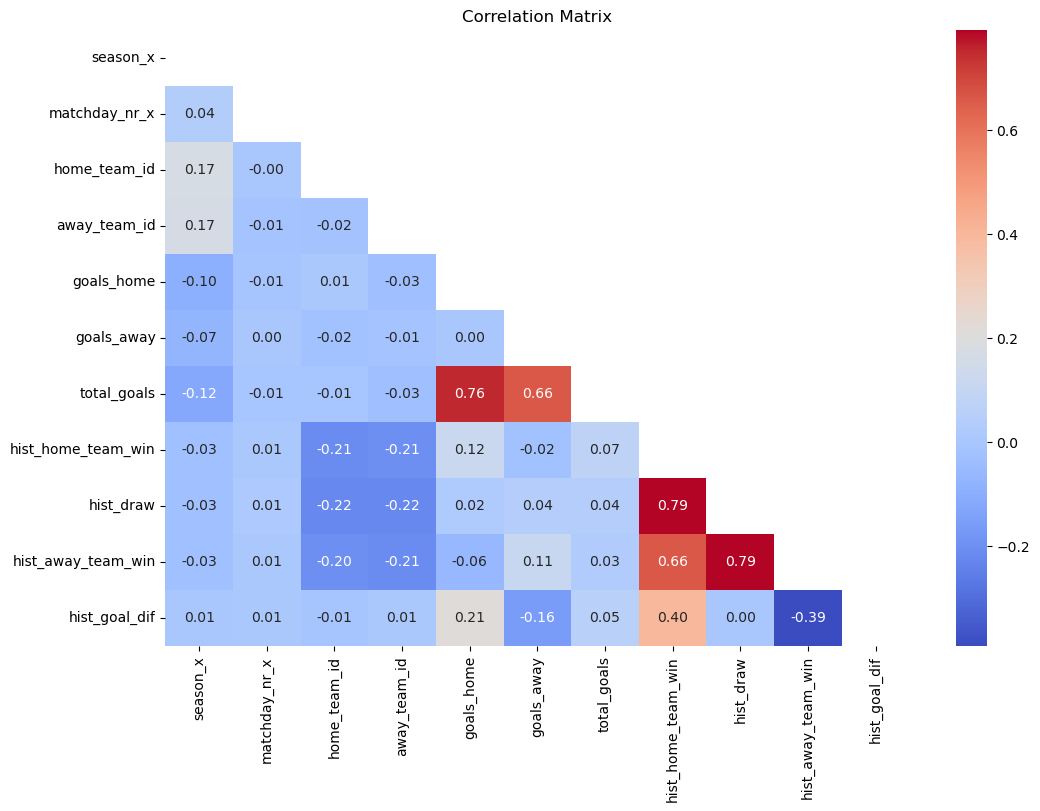

In [97]:
corr_matrix = final_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [98]:
final_df.to_csv('final_df.csv', index=False)

## <a id='64'>Modelling with new Features</a>

### Check how well the LogisticRegression performs

### Select Features

In [99]:
features = final_df[['season_x', 'matchday_nr_x', 'home_team_id', 'away_team_id', 'hist_home_team_win', 'hist_draw', 'hist_away_team_win', 'hist_goal_dif']]

### X-Y Split

In [100]:
X = features
y = final_df['outcome']

### Train-Test Split

In [101]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
# Create a Logistic Regression model
logreg = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)

In [103]:
# Train the model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42)

In [104]:
# Estimate the model performance using cross-validation on the training data
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5)

In [105]:
# Predict the outcomes on the testing data
predictions_log = logreg.predict(X_test)

In [106]:
# Show classification report
print(classification_report(y_test, predictions_log))

              precision    recall  f1-score   support

        draw       0.33      0.02      0.03       249
    win_away       0.35      0.20      0.26       216
    win_home       0.46      0.91      0.61       341

    accuracy                           0.44       806
   macro avg       0.38      0.38      0.30       806
weighted avg       0.39      0.44      0.34       806



In [107]:
cv_scores

array([0.45271318, 0.45807453, 0.4378882 , 0.45341615, 0.46118012])

In [108]:
pd.Series(predictions_log).value_counts()

win_home    670
win_away    124
draw         12
dtype: int64

In [109]:
y_test.value_counts()

win_home    341
draw        249
win_away    216
Name: outcome, dtype: int64

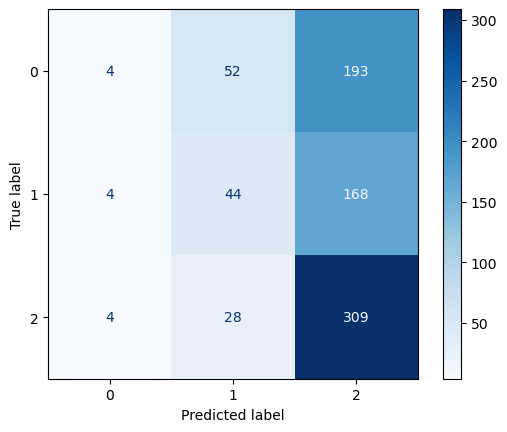

In [110]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions_log)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

### Feature Importance

#### Get the feature importance for the Logistic Regression model

In [111]:
# For logistic regression, the feature importance is based on the coefficients of the features
log_reg_coef = logreg.coef_[0]

# Create a pandas series with the coefficients
log_reg_feature_importance = pd.Series(log_reg_coef, index=X_train.columns)

# Display the feature importance
log_reg_feature_importance.sort_values(ascending=False)

hist_away_team_win    0.037819
hist_goal_dif         0.011907
hist_draw             0.011021
away_team_id         -0.000027
home_team_id         -0.000320
season_x             -0.000441
matchday_nr_x        -0.001556
hist_home_team_win   -0.045595
dtype: float64

This model indicates that the most important features are hist_away_team_win and hist_goal_difer. However, hist_home_team_win has a negative influence.

### Comparing these results to the previous iteration of the logistic regression model:

The current model shows some improvement over the previous one, particularly in its ability to predict draws and away wins, although it is still heavily biased towards predicting home wins. The incorporation of more data and potentially more features could help to improve the model's performance further.

### Check how well RandomForestClassifier performs

In [112]:
# Define a simpler grid of hyperparameters to search
simple_hyperparameter_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
}

rf = RandomForestClassifier(random_state=42)

In [113]:
# Set up the grid search with the simpler grid
simple_grid_cv = GridSearchCV(rf, simple_hyperparameter_grid, cv=5)

In [114]:
# Perform the grid search
simple_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10], 'n_estimators': [100, 200]})

In [115]:
# Get the best parameters
best_params_simple = simple_grid_cv.best_params_

In [116]:
# Train a random forest classifier with the best parameters
rf_best_simple = RandomForestClassifier(n_estimators=best_params_simple['n_estimators'], 
                                        max_depth=best_params_simple['max_depth'], 
                                        random_state=42)

rf_best_simple.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [117]:
# Predict the outcomes on the testing data
predictions_rf = rf_best_simple.predict(X_test)

In [118]:
# Show classification report
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

        draw       0.56      0.30      0.39       249
    win_away       0.49      0.33      0.39       216
    win_home       0.53      0.81      0.64       341

    accuracy                           0.52       806
   macro avg       0.52      0.48      0.47       806
weighted avg       0.53      0.52      0.50       806



In [119]:
# Estimate the model performance using cross-validation on the training data
cv_scores = cross_val_score(simple_grid_cv, X_train, y_train, cv=5)
cv_scores

array([0.54883721, 0.52018634, 0.54658385, 0.51397516, 0.55745342])

In [120]:
pd.Series(predictions_rf).value_counts()

win_home    527
win_away    145
draw        134
dtype: int64

In [121]:
y_test.value_counts()

win_home    341
draw        249
win_away    216
Name: outcome, dtype: int64

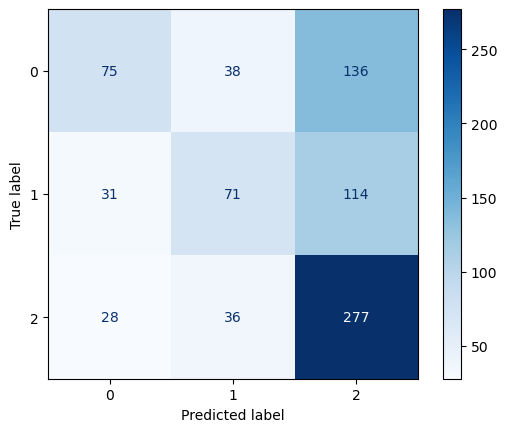

In [122]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions_rf)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

### Feature Importance

#### Get the feature importance for the RandomForest model

In [123]:
# For RandomForest, we can use the feature_importances_ attribute
rf_feature_importance = rf_best_simple.feature_importances_

# Create a pandas series with the feature importances
rf_feature_importance = pd.Series(rf_feature_importance, index=X_train.columns)

# Display the feature importance
rf_feature_importance.sort_values(ascending=False)

hist_goal_dif         0.163412
matchday_nr_x         0.130780
hist_away_team_win    0.129138
season_x              0.120339
hist_home_team_win    0.119971
home_team_id          0.118934
away_team_id          0.109331
hist_draw             0.108095
dtype: float64

According to this model, the most impactful features are hist_goal_diff, match_day_nr_x, hist_away_team_win, and season_x, all with similar importance.

### In comparison to the previous iteration of the RandomForestClassifier model

The overall accuracy of the model on the test data is 0.50, indicating that the model makes accurate predictions for unseen data around 50% of the time.

The current model demonstrates an improvement over the previous one, especially in its ability to predict draws and away wins. However, it still leans toward predicting home wins.

### Check how well Gradient Boosting (using XGBoost) performs

In [124]:
# Create and train the model
model = XGBClassifier(use_label_encoder=False)

In [125]:
# Create a label encoder object
le = LabelEncoder()

# Fit the encoder to the 'y' data
y_encoded = le.fit_transform(y)

### Train-Test Split

In [126]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [127]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [128]:
# Predict the outcomes on the test set
y_pred = model.predict(X_test)

In [129]:
# Show classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.46      0.53       249
           1       0.46      0.48      0.47       216
           2       0.60      0.70      0.65       341

    accuracy                           0.57       806
   macro avg       0.56      0.55      0.55       806
weighted avg       0.57      0.57      0.56       806



In [130]:
pd.Series(y_pred).value_counts()

2    399
1    222
0    185
dtype: int64

In [131]:
pd.Series(y_test).value_counts()

2    341
0    249
1    216
dtype: int64

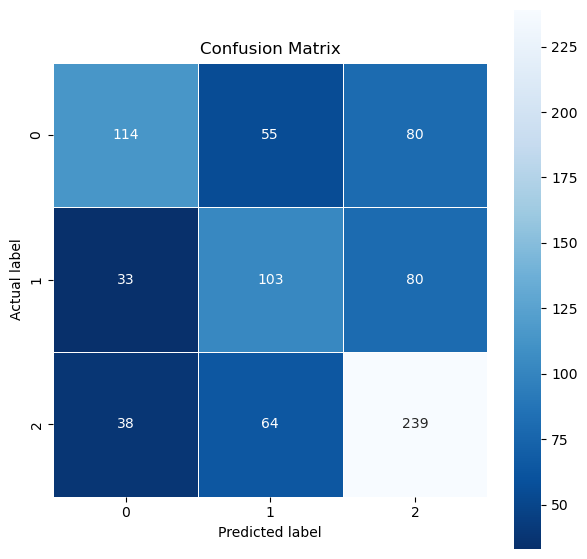

In [132]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix');

### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

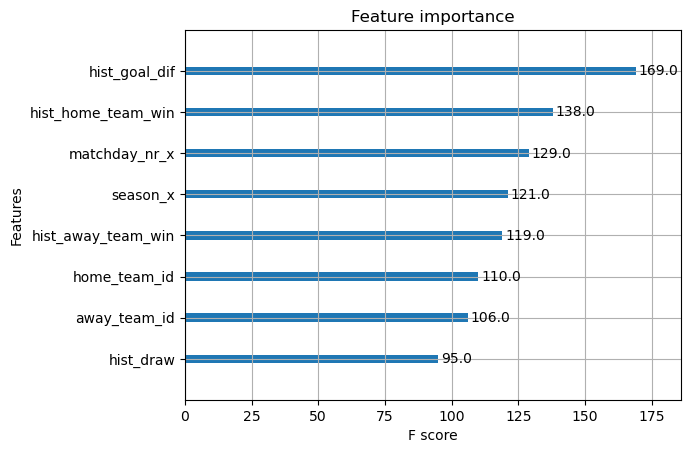

In [133]:
# To get feature importances for XGBoost, we first need to create a DMatrix object for the data
# This is a requirement for using the plot_importance function
import xgboost as xgb

# Create DMatrix for train and test
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify parameters via map, definition are same as c++ version
param = {'max_depth':3, 'eta':0.3, 'objective':'multi:softprob', 'num_class':3}

# Train the model using a small number of boosting rounds and the early stopping feature
# This will prevent overfitting and reduce the chance of running out of memory
num_round = 50
bst = xgb.train(param, dtrain, num_round)

# Plot feature importances
xgb.plot_importance(bst)

This model assigns the highest importance to hist_goal_dif, followed by hist_away_team_win and match_day_nr_x.

### Present results

In the first round of modelling, the accuracy of the model was 0.41, but after refining the model, the accuracy increased to 0.57. This shows a substantial improvement in the model's ability to correctly predict the outcome of a match.

These improvements suggest that the refined model is more effective at correctly predicting the outcome of a match, and it's better at identifying each class than the initial model.

### Check how well k-nearest neighbors performs

In [134]:
# List of possible n_neighbors to try
n_neighbors = list(range(1, 100))

In [135]:
# List to store the average cross-validation score for each value of n_neighbors
cv_scores = []

In [136]:
# Perform 5-fold cross-validation for each value of n_neighbors
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

In [137]:
# Determine the best n_neighbors
best_n_neighbors = n_neighbors[cv_scores.index(max(cv_scores))]
best_n_neighbors, max(cv_scores)

(1, 0.5476556406182291)

In [138]:
# Train the KNN model on the training data
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [139]:
# Make predictions on the test data
y_pred = knn.predict(X_test)

In [140]:
# Show classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53       249
           1       0.50      0.50      0.50       216
           2       0.62      0.68      0.65       341

    accuracy                           0.57       806
   macro avg       0.56      0.56      0.56       806
weighted avg       0.57      0.57      0.57       806



In [141]:
# Estimate the model performance using cross-validation on the training data
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
cv_scores

array([0.54883721, 0.55279503, 0.56987578, 0.50310559, 0.5636646 ])

In [142]:
pd.Series(y_pred).value_counts()

2    371
0    220
1    215
dtype: int64

In [143]:
pd.Series(y_test).value_counts()

2    341
0    249
1    216
dtype: int64

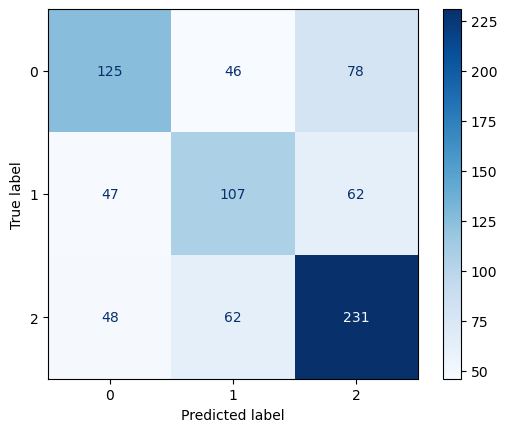

In [144]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

### Feature Importance

In [145]:
# Fit a KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Compute permutation feature importance
perm_importance = permutation_importance(knn, X_test, y_test)

# Create a pandas series with the feature importances
knn_feature_importance = pd.Series(perm_importance.importances_mean, index=X_train.columns)

# Display the feature importance
knn_feature_importance.sort_values(ascending=False)

home_team_id          0.084367
away_team_id          0.067246
hist_goal_dif         0.065757
hist_home_team_win    0.034491
matchday_nr_x         0.032010
hist_draw             0.031017
season_x              0.020099
hist_away_team_win    0.016377
dtype: float64

Based on permutation feature importance, home_team_id and away_team_id are the most influential features, followed by hist_goal_dif.

### Present results

In the first round of modelling, the accuracy of the model was 0.42, but after refining the model, the accuracy increased to 0.57. This represents a significant improvement in the model's ability to correctly predict the outcome of a match.

These improvements suggest that the refined model is more effective at correctly predicting the outcome of a match, and it's better at identifying each class than the initial model.

## <a id='65'>Conclusion</a>

Model refinement played a pivotal role in improving the performance of all our models. The refinement process ignificantly enhanced the precision, recall, and F1-score for each class, along with the overall accuracy of the models.

The most noteworthy improvements were seen in the Gradient Boosting and K-Nearest Neighbors models, both of which saw their accuracies increase from around 0.41-0.42 to 0.57. The Logistic Regression model's accuracy increased slightly from 0.43 to 0.44, while its macro-average F1-score also rose from 0.21 to 0.30. The RandomForest model, too, experienced improvements with the accuracy increasing from 0.46 to 0.52 and the macro-average F1-score improving from 0.40 to 0.47.

The feature importance shows varying results across different models, which is normal as different models have different ways of attribinating importance to features. In general, it seems that historical data (hist_away_team_win, hist_goal_dif, hist_home_team_win, hist_draw) and team-related data (home_team_id, away_team_id) tend to be important across all models. These features should be given special attention when performing feature selection, engineering, and extraction.

<a href="#0"><font size="1">Go to top</font></a>  

# <a id='7'>Predicting the 23/24 Bundesliga games</a>  

After training our models we want to use them to predict future games in the Bundesliga. Therefore, we will now load a new data set containing the game plan of the new season 2023/24.

In [146]:
df16 = pd.read_csv('future_game_plan_23_24.csv')
df16

,matchday_nr,home_team_name,away_team_name,hist_home_team_win,hist_draw,hist_away_team_win,hist_goal_dif,season,home_team_id,away_team_id
0,1,Werder Bremen,FC Bayern München,26,26,60,-102.0,2023,134.0,40.0
1,1,VfB Stuttgart,VfL Bochum,37,20,15,39.0,2023,16.0,129.0
2,1,Borussia Dortmund,1. FC Köln,40,25,29,28.0,2023,7.0,65.0
3,1,Eintracht Frankfurt,SV Darmstadt 98,5,0,3,5.0,2023,91.0,118.0
4,1,Bayer Leverkusen,RB Leipzig,3,4,7,-4.0,2023,6.0,1635.0
...,...,...,...,...,...,...,...,...,...,...
267,34,Eintracht Frankfurt,RB Leipzig,3,7,4,1.0,2024,91.0,1635.0
268,34,Bayer Leverkusen,FC Augsburg,15,7,2,31.0,2024,6.0,95.0
269,34,VfL Wolfsburg,1. FSV Mainz 05,19,15,10,20.0,2024,131.0,81.0
270,34,1. FC Union Berlin,SC Freiburg,5,3,4,-3.0,2024,80.0,112.0


In [147]:
# Rename the columns in 'df16'
column_mapping = {
    'matchday_nr': 'matchday_nr_x',
    'season': 'season_x'
}

In [148]:
df16 = df16.rename(columns=column_mapping)
df16

,matchday_nr_x,home_team_name,away_team_name,hist_home_team_win,hist_draw,hist_away_team_win,hist_goal_dif,season_x,home_team_id,away_team_id
0,1,Werder Bremen,FC Bayern München,26,26,60,-102.0,2023,134.0,40.0
1,1,VfB Stuttgart,VfL Bochum,37,20,15,39.0,2023,16.0,129.0
2,1,Borussia Dortmund,1. FC Köln,40,25,29,28.0,2023,7.0,65.0
3,1,Eintracht Frankfurt,SV Darmstadt 98,5,0,3,5.0,2023,91.0,118.0
4,1,Bayer Leverkusen,RB Leipzig,3,4,7,-4.0,2023,6.0,1635.0
...,...,...,...,...,...,...,...,...,...,...
267,34,Eintracht Frankfurt,RB Leipzig,3,7,4,1.0,2024,91.0,1635.0
268,34,Bayer Leverkusen,FC Augsburg,15,7,2,31.0,2024,6.0,95.0
269,34,VfL Wolfsburg,1. FSV Mainz 05,19,15,10,20.0,2024,131.0,81.0
270,34,1. FC Union Berlin,SC Freiburg,5,3,4,-3.0,2024,80.0,112.0


In [149]:
df16_features = df16[['season_x', 'matchday_nr_x', 'home_team_id', 'away_team_id', 'hist_home_team_win', 'hist_draw', 'hist_away_team_win', 'hist_goal_dif']]
df16_features

,season_x,matchday_nr_x,home_team_id,away_team_id,hist_home_team_win,hist_draw,hist_away_team_win,hist_goal_dif
0,2023,1,134.0,40.0,26,26,60,-102.0
1,2023,1,16.0,129.0,37,20,15,39.0
2,2023,1,7.0,65.0,40,25,29,28.0
3,2023,1,91.0,118.0,5,0,3,5.0
4,2023,1,6.0,1635.0,3,4,7,-4.0
...,...,...,...,...,...,...,...,...
267,2024,34,91.0,1635.0,3,7,4,1.0
268,2024,34,6.0,95.0,15,7,2,31.0
269,2024,34,131.0,81.0,19,15,10,20.0
270,2024,34,80.0,112.0,5,3,4,-3.0


## Logistic Regression

In [150]:
predictions_logreg = logreg.predict(df16_features)

In [151]:
# Create a new DataFrame with the predictions and relevant information
results_df = df16[['home_team_name', 'away_team_name']].copy()
results_df['predictions'] = predictions_logreg
results_df

,home_team_name,away_team_name,predictions
0,Werder Bremen,FC Bayern München,win_away
1,VfB Stuttgart,VfL Bochum,win_home
2,Borussia Dortmund,1. FC Köln,win_home
3,Eintracht Frankfurt,SV Darmstadt 98,win_home
4,Bayer Leverkusen,RB Leipzig,win_home
...,...,...,...
267,Eintracht Frankfurt,RB Leipzig,win_home
268,Bayer Leverkusen,FC Augsburg,win_home
269,VfL Wolfsburg,1. FSV Mainz 05,win_home
270,1. FC Union Berlin,SC Freiburg,win_home


In [152]:
# Create a new column for points earned by home and away teams
results_df['home_points'] = results_df['predictions'].apply(lambda x: 3 if x == 'win_home' else (1 if x == 'draw' else 0))
results_df['away_points'] = results_df['predictions'].apply(lambda x: 3 if x == 'win_away' else (1 if x == 'draw' else 0))

In [153]:
# Calculate the total points for each team
home_points = results_df.groupby('home_team_name')['home_points'].sum()
away_points = results_df.groupby('away_team_name')['away_points'].sum()
total_points = home_points.add(away_points, fill_value=0)

In [154]:
# Get the top 10 teams
top_10_teams = total_points.nlargest(18)
top_10_teams

home_team_name
FC Bayern München           87
RB Leipzig                  72
Borussia Dortmund           72
Bayer Leverkusen            64
VfL Wolfsburg               51
Werder Bremen               49
1. FC Union Berlin          48
SV Darmstadt 98             48
VfB Stuttgart               48
TSG 1899 Hoffenheim         42
Borussia Mönchengladbach    39
1. FC Köln                  39
SC Freiburg                 36
1. FSV Mainz 05             36
Eintracht Frankfurt         30
FC Augsburg                 30
VfL Bochum                  24
dtype: int64

## RandomForestClassifier

In [155]:
predictions_rf = rf_best_simple.predict(df16_features)

In [156]:
# Create a new DataFrame with the predictions and relevant information
results_df = df16[['home_team_name', 'away_team_name']].copy()
results_df['predictions'] = predictions_rf
results_df

,home_team_name,away_team_name,predictions
0,Werder Bremen,FC Bayern München,win_away
1,VfB Stuttgart,VfL Bochum,win_home
2,Borussia Dortmund,1. FC Köln,win_home
3,Eintracht Frankfurt,SV Darmstadt 98,win_home
4,Bayer Leverkusen,RB Leipzig,draw
...,...,...,...
267,Eintracht Frankfurt,RB Leipzig,win_home
268,Bayer Leverkusen,FC Augsburg,win_home
269,VfL Wolfsburg,1. FSV Mainz 05,win_home
270,1. FC Union Berlin,SC Freiburg,win_home


In [157]:
# Create a new column for points earned by home and away teams
results_df['home_points'] = results_df['predictions'].apply(lambda x: 3 if x == 'win_home' else (1 if x == 'draw' else 0))
results_df['away_points'] = results_df['predictions'].apply(lambda x: 3 if x == 'win_away' else (1 if x == 'draw' else 0))

In [158]:
# Calculate the total points for each team
home_points = results_df.groupby('home_team_name')['home_points'].sum()
away_points = results_df.groupby('away_team_name')['away_points'].sum()
total_points = home_points.add(away_points, fill_value=0)

In [159]:
# Get the top 10 teams
top_10_teams = total_points.nlargest(18)
top_10_teams

home_team_name
FC Bayern München           75
Borussia Dortmund           68
Bayer Leverkusen            65
RB Leipzig                  61
Borussia Mönchengladbach    51
1. FC Union Berlin          45
SV Darmstadt 98             44
SC Freiburg                 42
1. FSV Mainz 05             41
VfL Wolfsburg               41
VfB Stuttgart               40
Eintracht Frankfurt         40
Werder Bremen               36
TSG 1899 Hoffenheim         35
VfL Bochum                  34
1. FC Köln                  34
FC Augsburg                 33
dtype: int64

## Gradient Boosting (using XGBoost)

In [160]:
predictions_XGBoost = model.predict(df16_features)

In [161]:
# Create a new DataFrame with the predictions and relevant information
results_df = df16[['home_team_name', 'away_team_name']].copy()
results_df['predictions'] = predictions_XGBoost
results_df

,home_team_name,away_team_name,predictions
0,Werder Bremen,FC Bayern München,1
1,VfB Stuttgart,VfL Bochum,2
2,Borussia Dortmund,1. FC Köln,2
3,Eintracht Frankfurt,SV Darmstadt 98,2
4,Bayer Leverkusen,RB Leipzig,0
...,...,...,...
267,Eintracht Frankfurt,RB Leipzig,2
268,Bayer Leverkusen,FC Augsburg,2
269,VfL Wolfsburg,1. FSV Mainz 05,2
270,1. FC Union Berlin,SC Freiburg,2


In [162]:
# Adjust the function to calculate points based on the new outcomes (1 = win_home, 2 = win_away, 0 = draw)
def calculate_points_new(predictions, games_df):
    results_df = games_df[['home_team_name', 'away_team_name']].copy()
    results_df['predictions'] = predictions
    results_df['home_points'] = results_df['predictions'].apply(lambda x: 3 if x == 1 else (1 if x == 0 else 0))
    results_df['away_points'] = results_df['predictions'].apply(lambda x: 3 if x == 2 else (1 if x == 0 else 0))
    home_points = results_df.groupby('home_team_name')['home_points'].sum()
    away_points = results_df.groupby('away_team_name')['away_points'].sum()
    total_points = home_points.add(away_points, fill_value=0)
    top_10_teams = total_points.nlargest(10)
    return top_10_teams

In [163]:
# Calculate points for XGBoost model
top_10_teams_XGBoost = calculate_points_new(predictions_XGBoost, df16)
top_10_teams_XGBoost

home_team_name
FC Augsburg                 69
SV Darmstadt 98             63
TSG 1899 Hoffenheim         61
VfL Bochum                  58
VfB Stuttgart               56
VfL Wolfsburg               55
Eintracht Frankfurt         49
1. FSV Mainz 05             46
Borussia Mönchengladbach    42
Werder Bremen               42
dtype: int64

## k-nearest neighbours

In [164]:
predictions_knn = knn.predict(df16_features)

In [165]:
# Create a new DataFrame with the predictions and relevant information
results_df = df16[['home_team_name', 'away_team_name']].copy()
results_df['predictions'] = predictions_knn
results_df

,home_team_name,away_team_name,predictions
0,Werder Bremen,FC Bayern München,1
1,VfB Stuttgart,VfL Bochum,2
2,Borussia Dortmund,1. FC Köln,2
3,Eintracht Frankfurt,SV Darmstadt 98,0
4,Bayer Leverkusen,RB Leipzig,0
...,...,...,...
267,Eintracht Frankfurt,RB Leipzig,1
268,Bayer Leverkusen,FC Augsburg,2
269,VfL Wolfsburg,1. FSV Mainz 05,1
270,1. FC Union Berlin,SC Freiburg,2


In [166]:
# Calculate points for k-nearest neighbours model
top_10_teams_knn = calculate_points_new(predictions_knn, df16)
top_10_teams_knn

home_team_name
1. FC Union Berlin     54
FC Augsburg            53
SV Darmstadt 98        52
TSG 1899 Hoffenheim    52
1. FSV Mainz 05        51
VfL Wolfsburg          49
SC Freiburg            48
Werder Bremen          48
1. FC Köln             45
Eintracht Frankfurt    43
dtype: int64

<a href="#0"><font size="1">Go to top</font></a>  

# <a id='8'>Conclusions</a>  

**Pontential Improvement**

When predicting the outcomes of sports matches, there are several categories of features that can be useful. Here are some ideas for additional features that one could consider:

- Team Strength: You could add features that represent the strength of each team. This could be based on their FIFA ratings, their position in the league table, their average goal difference over the season, or any other measure of team strength.

- Recent Form: The performance of the teams in their recent matches can be a good predictor of their performance in the upcoming match. You could add features that represent the recent form of each team, such as their win-loss record in the last 5 or 10 matches, the average goal difference in these matches, etc.

- Player-Based Features: If you have data on the players who are going to play in the match, you could add features based on this. This could include the average age or number of international caps of the players, the number of injuries, etc.

- Venue-Based Features: The venue of the match can have a big impact on the result. You could add features that represent the venue, such as the altitude of the stadium, the average temperature or rainfall, the size of the crowd, etc.

- Tactical Features: If you have data on the tactics used by the teams, you could add features based on this. This could include the formation used by the team, the style of play (e.g., possession-based, counter-attacking), etc.

<a href="#0"><font size="1">Go to top</font></a>  